## 구글 연동 및 경로 설정

In [4]:
from google.colab import drive # 패키지 불러오기 
from os.path import join  

ROOT = "/content/drive"     # 드라이브 기본 경로
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)           # 드라이브 기본 경로 Mount

/content/drive
Mounted at /content/drive


In [5]:
MY_GOOGLE_DRIVE_PATH = 'My Drive/Colab Notebooks/NLP/텐서플로2와 머신러닝으로 시작하는 자연어처리' # 프로젝트 경로
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH) # 프로젝트 경로
print(PROJECT_PATH)

/content/drive/My Drive/Colab Notebooks/NLP/텐서플로2와 머신러닝으로 시작하는 자연어처리


In [6]:
cd "{PROJECT_PATH}"

/content/drive/My Drive/Colab Notebooks/NLP/텐서플로2와 머신러닝으로 시작하는 자연어처리


# CH07_사전 학습 모델_ 버트(BERT)  
- 사전 학습 모델 : 기존에 자비어(Xavier) 등 임의의 값으로 초기화하던 모델의 가중치들을 다른 문제(task)에 학습시킨 가중치들로 초기화하는 방법
    - 하위 문제(downstream task) : 사전 학습한 가중치를 활용해 학습하고자 하는 본 문제 
    - 사전 학습 문제(pre-train task) : 사전 학습한 모델  

ex) 
*텍스트 유사도 예측 모델을 만들기 전 감정 분석 문제를 학습한 모델의 가중치를 활용해 텍스트 유사도 모델의 가중치로 활용하는 방법.  
즉, 감정 분석 문제를 학습하면서 얻은 언어에 대한 이해를 학습한 후 그 정보를 유사도 문제를 학습하는 데 활용하는 방식*  

=> 주로 당장 활용할 데이터가 많지 않아 가중치를 초기화해서 부여하는 것이 적절치 못할 때 사전에 학습된 모델에 가중치를 활용하는 것

- 감정 분석 데이터셋에서 사전 학습한 가중치를 유사도 문제를 해결하기 위한 모델의 초깃값으로 활용 
- 여기서 유의할 점은 모델의 모든 가중치를 사용하는 것이 아니라 모델의 최종 출력값을 뽑는 가중치 층을 제외하고 사용
- 이유는 최종 출력값의 경우 각 문제마다 형태가 모두 다르기 때문

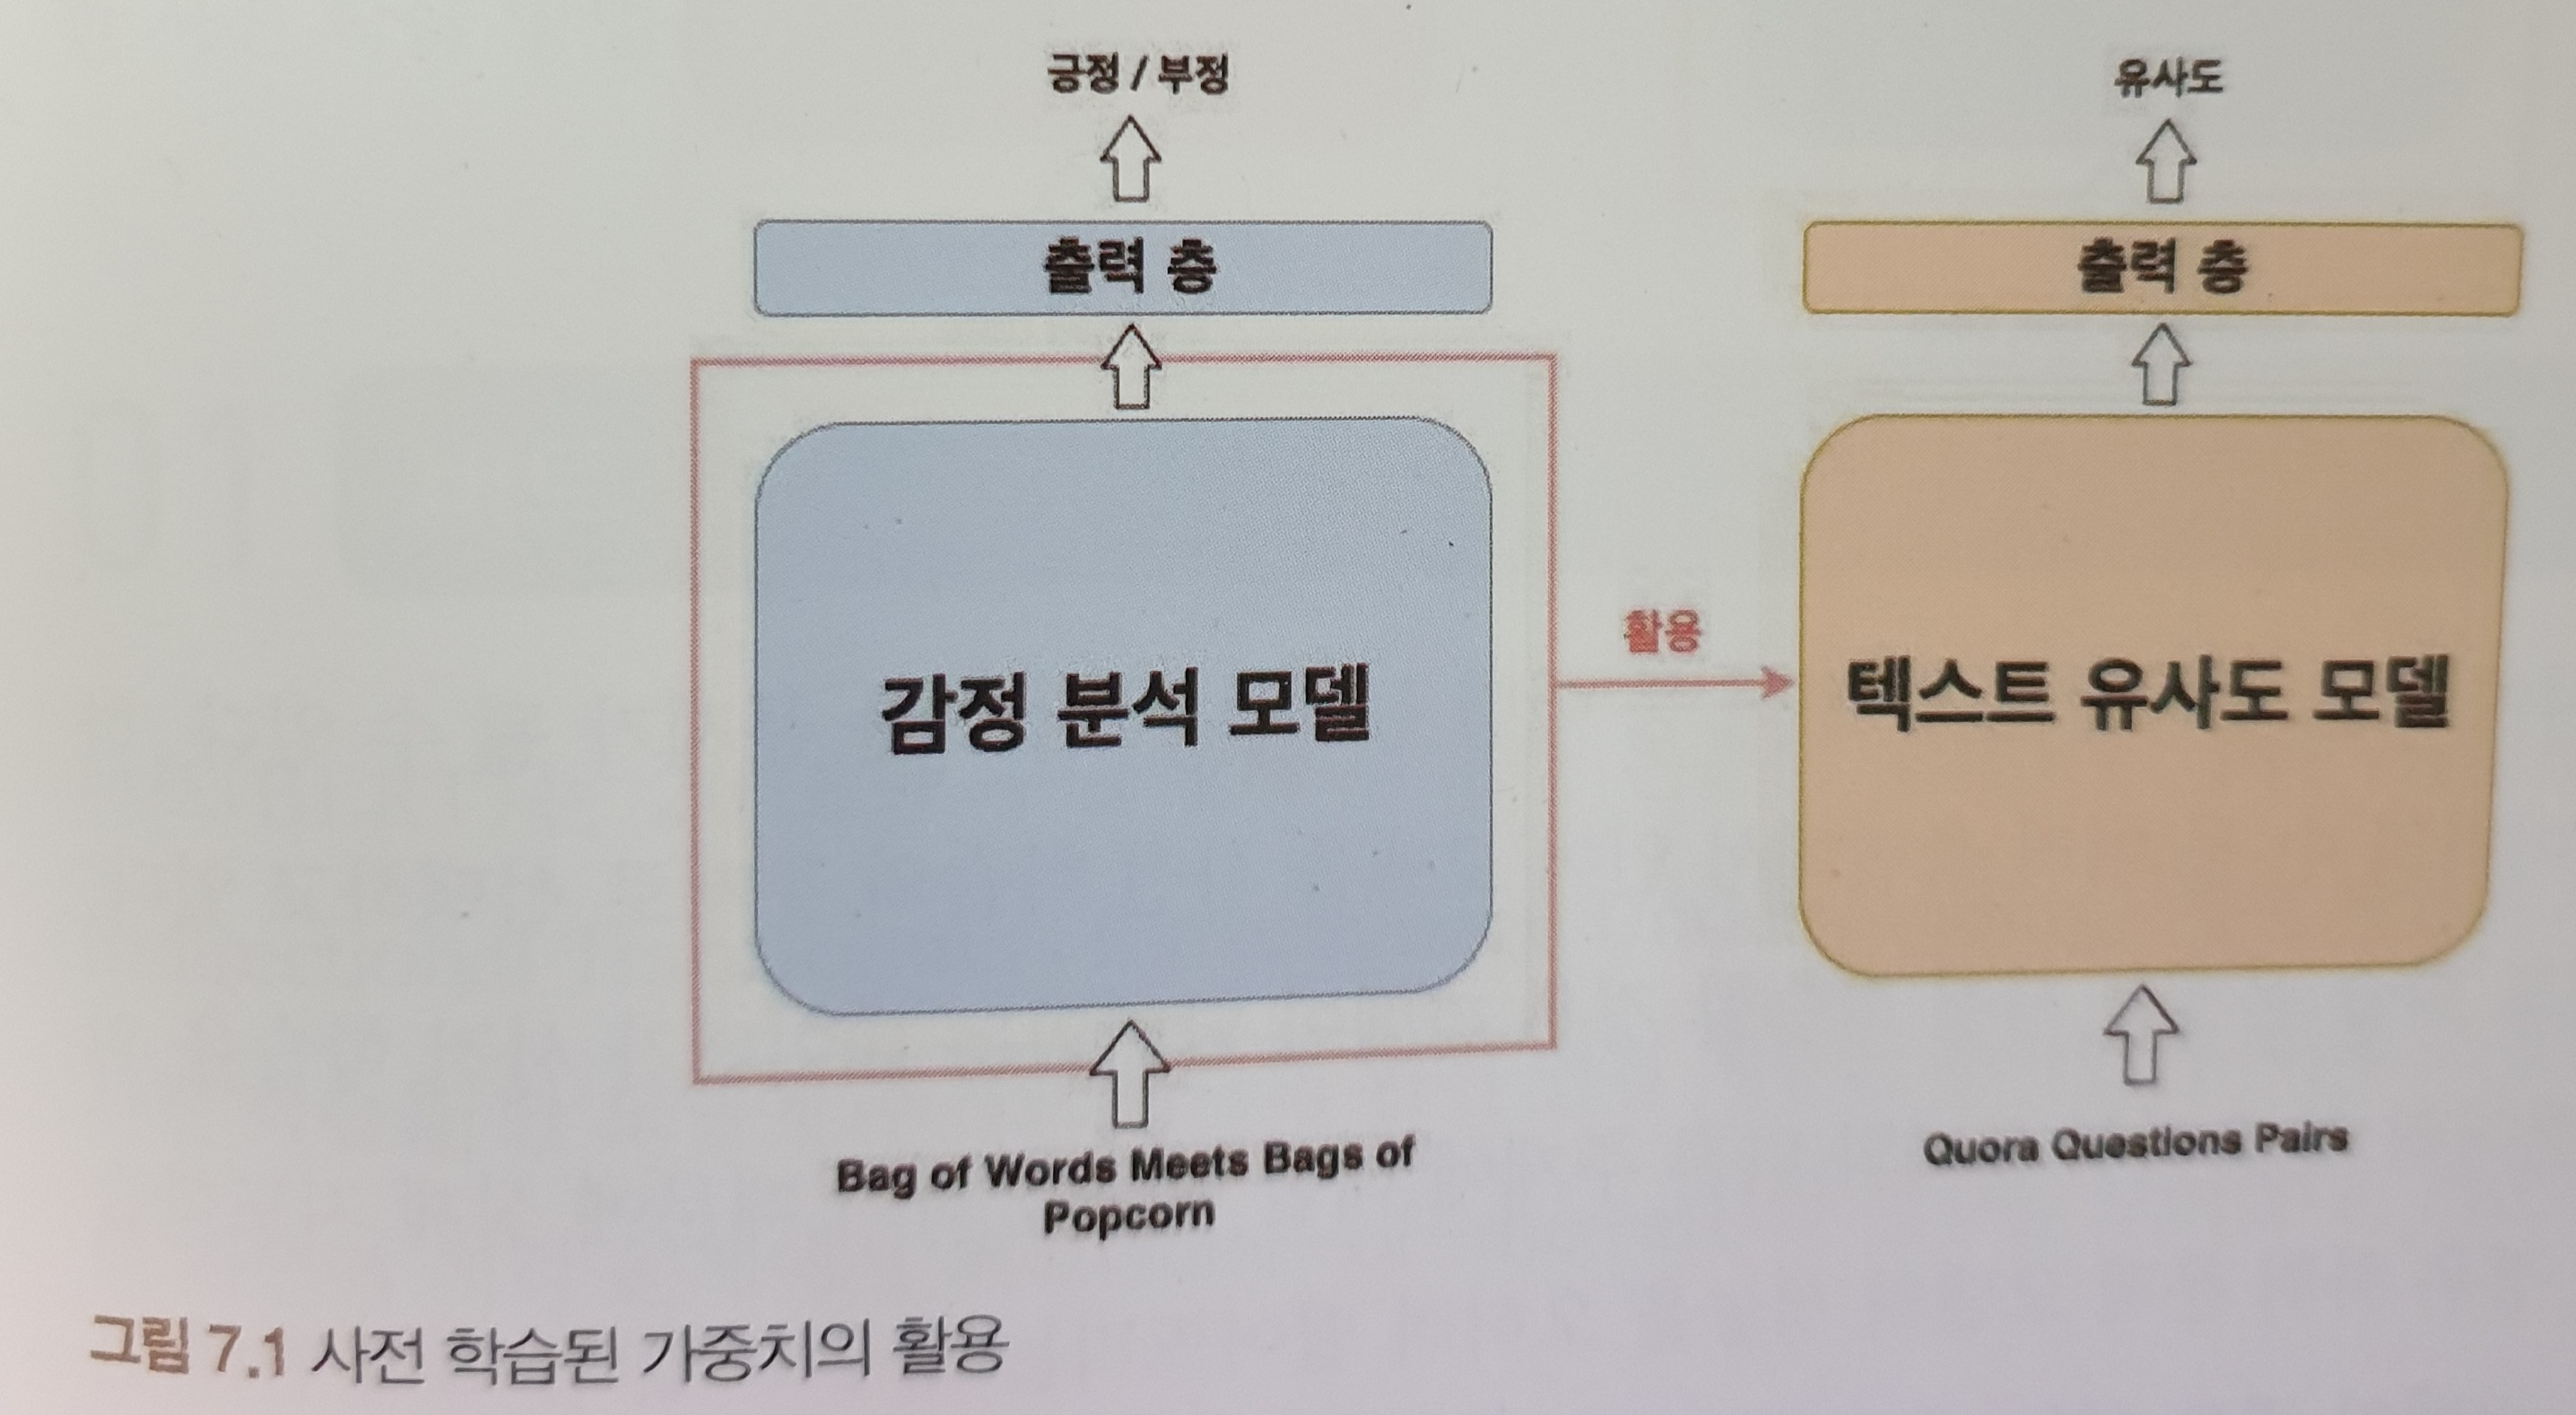

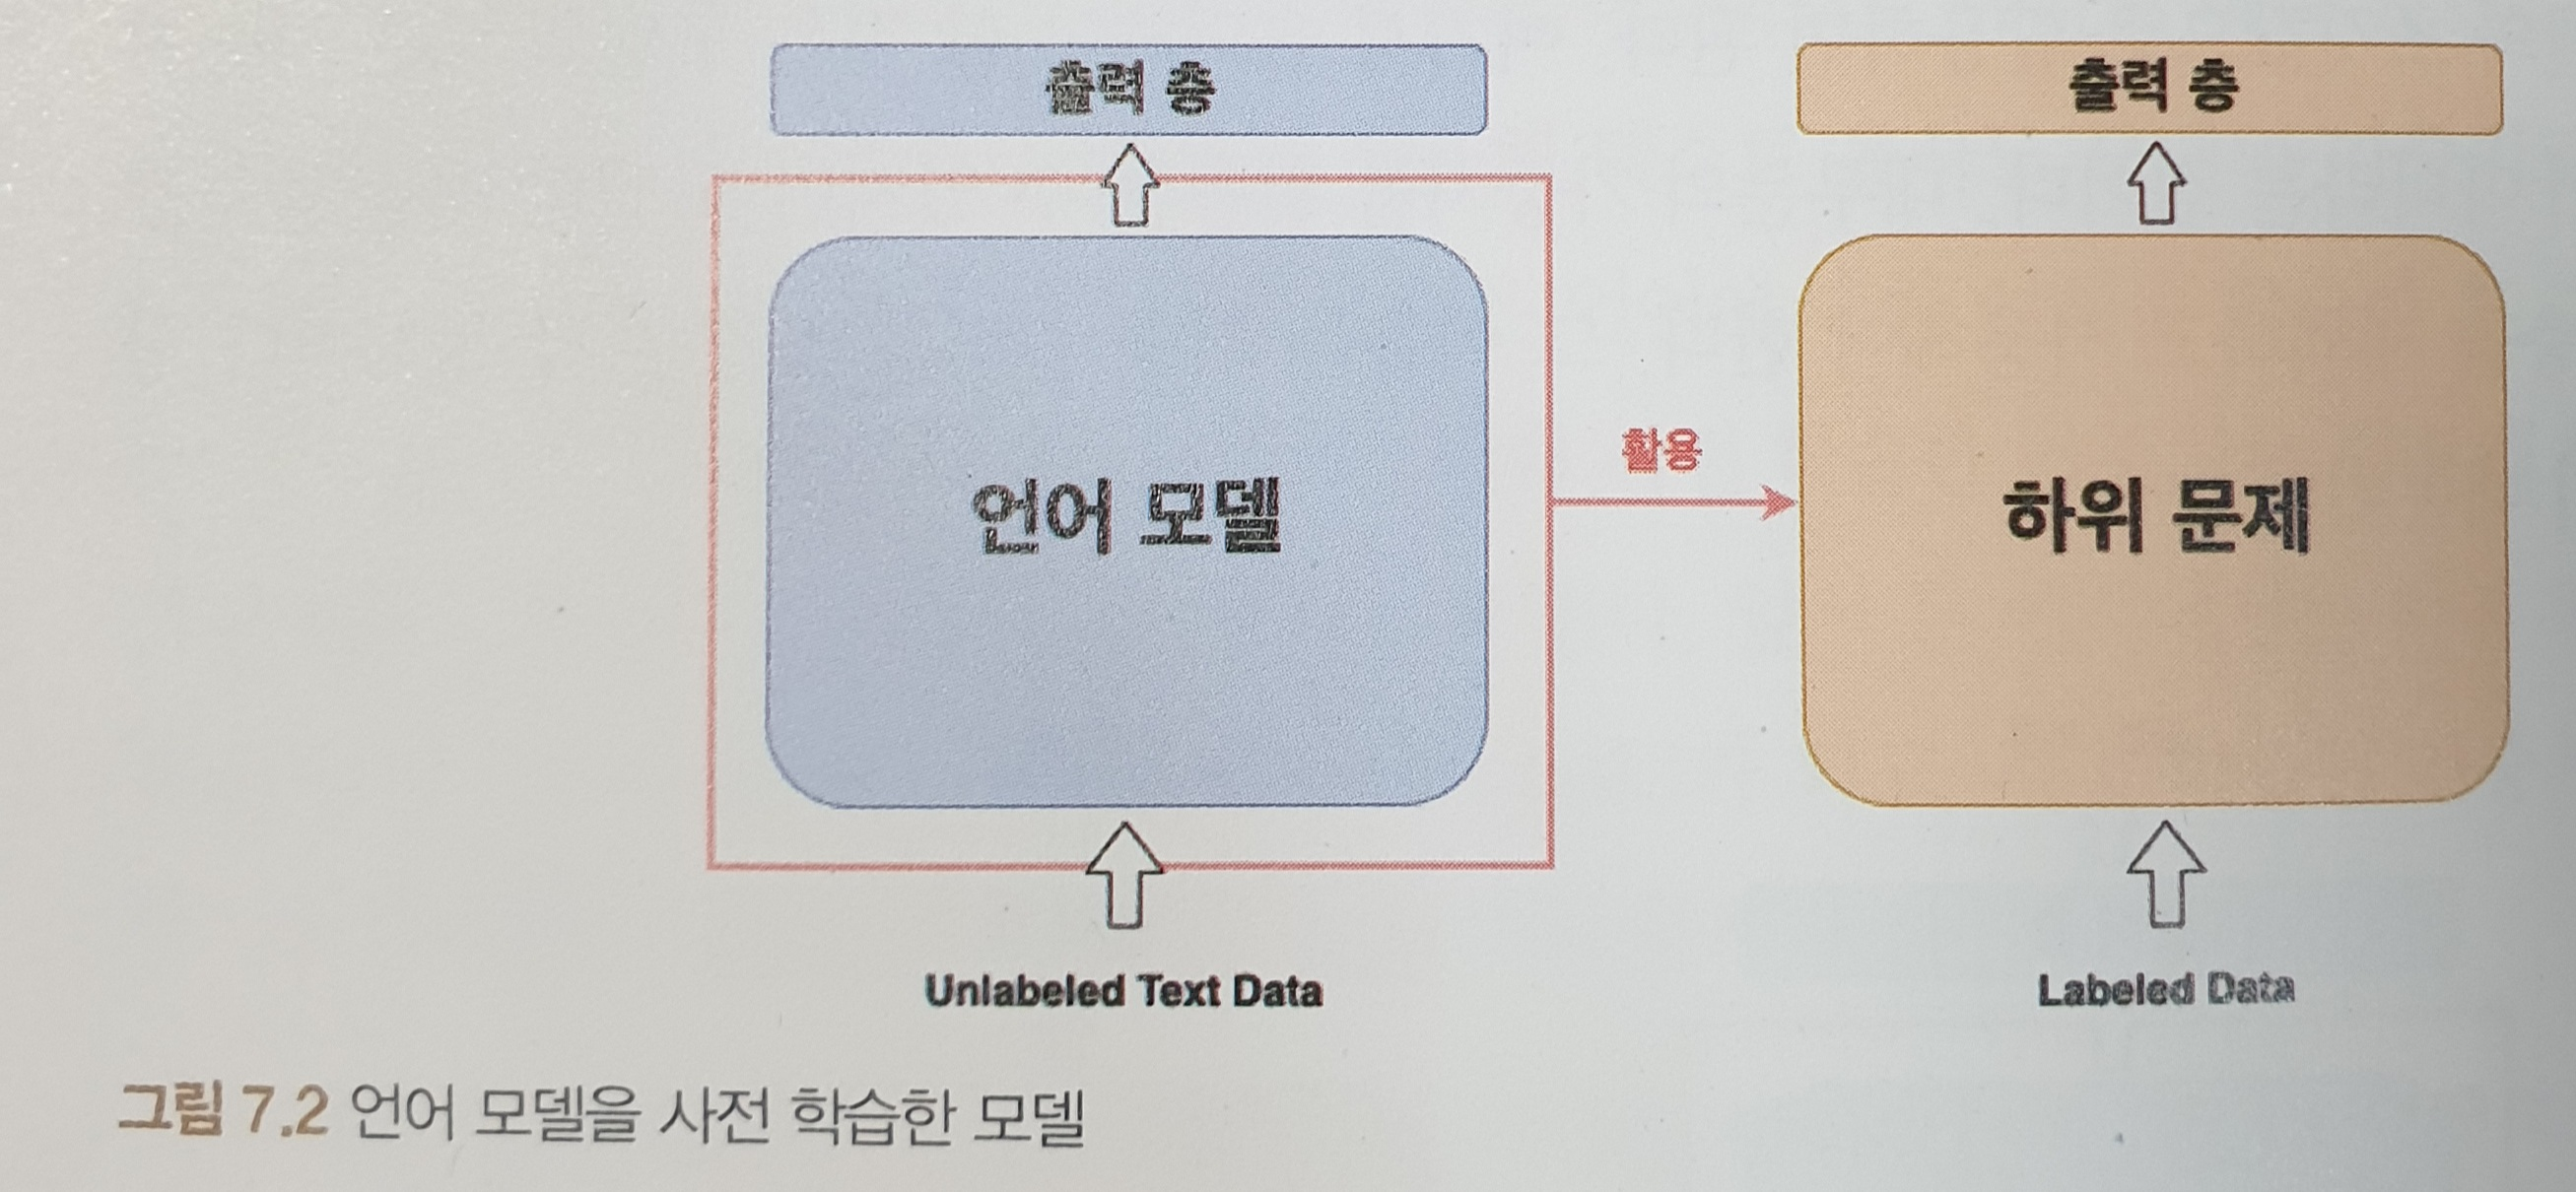

**사전 학습한 가중치를 활용하는 방법** 
1. 특징 기반(feature-based) : 사전 학습된 특징을 하위 문제의 모델에 부가적인 특징으로 활용하는 방법  

ex) *word2vec으로 학습한 임베딩 특징* 

2. 미세 조정(fine-tuning) : 사전 학습한 모든 가중치와 더불어 하위 문제를 위한 **최소한의 가중치를 추가**해서 모델을 추가로 학습(미세 조정)하는 방법 

## 1. 버트(BERT)  
- 버트(BERT)는 2018년 구글에서 공개한 논문인 << BERT : Pre-training of Deep Bidirectional Transformers for Language Understanding>>에서 제안된 모델 
- 비지도 사전 학습을 한 모델에 추가로 하나의 완전 연결 계층만 추가한 후 미세 조정을 통해 총 11개의 자연어 처리 문제에서 최고(state-of-the-art)의 성능을 보여줌
- 기존 사전 학습 모델인 GPT, ELMo 등의 모델보다 좋은 성능 
- 기존 모델들과의 차이점은 모델이 **양방향성(bibirectional)**을 띤다는 점  

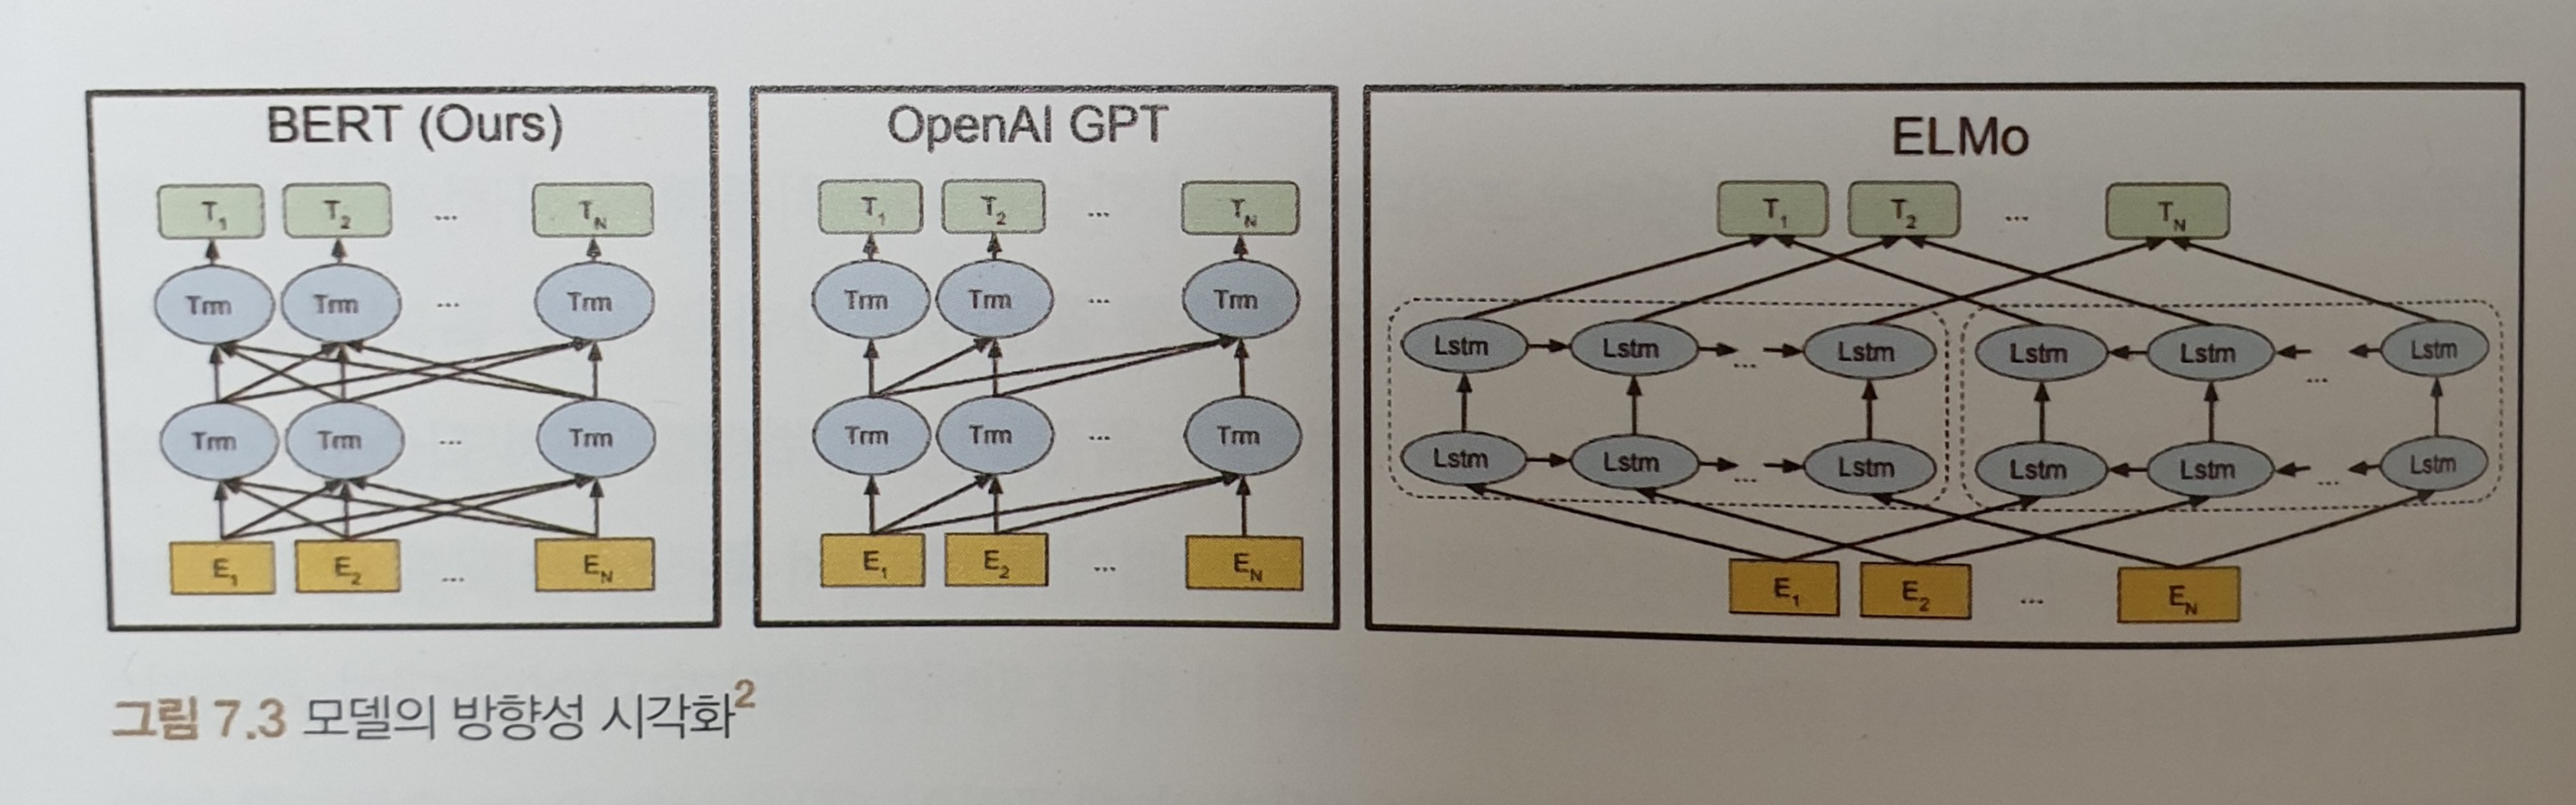
- 버트만 양방향성을 가지고 학습하는 이유는 버트의 사전 학습 문제 중 하나인 마스크 언어 모델(Masked language modeling)을 학습하기 때문

### 1) 버트의 사전 학습 문제  
**언어 모델(Language modeling)** : 단어들의 시퀀스에 대한 확률 분포 → 단어들의 모음이 있을 때 해당 단어의 모음이 어떤 확률로 등장할지를 나타내는 값

- **Word2vec의 CBOW 모델** : 특정 위치 주변에 있는 단어가 주어졌을 때 특정 위치에 나올 단어를 예측하는 모델. 즉, 주변 단어들을 포함한 단어들의 수열의 확률을 예측하는 모델  
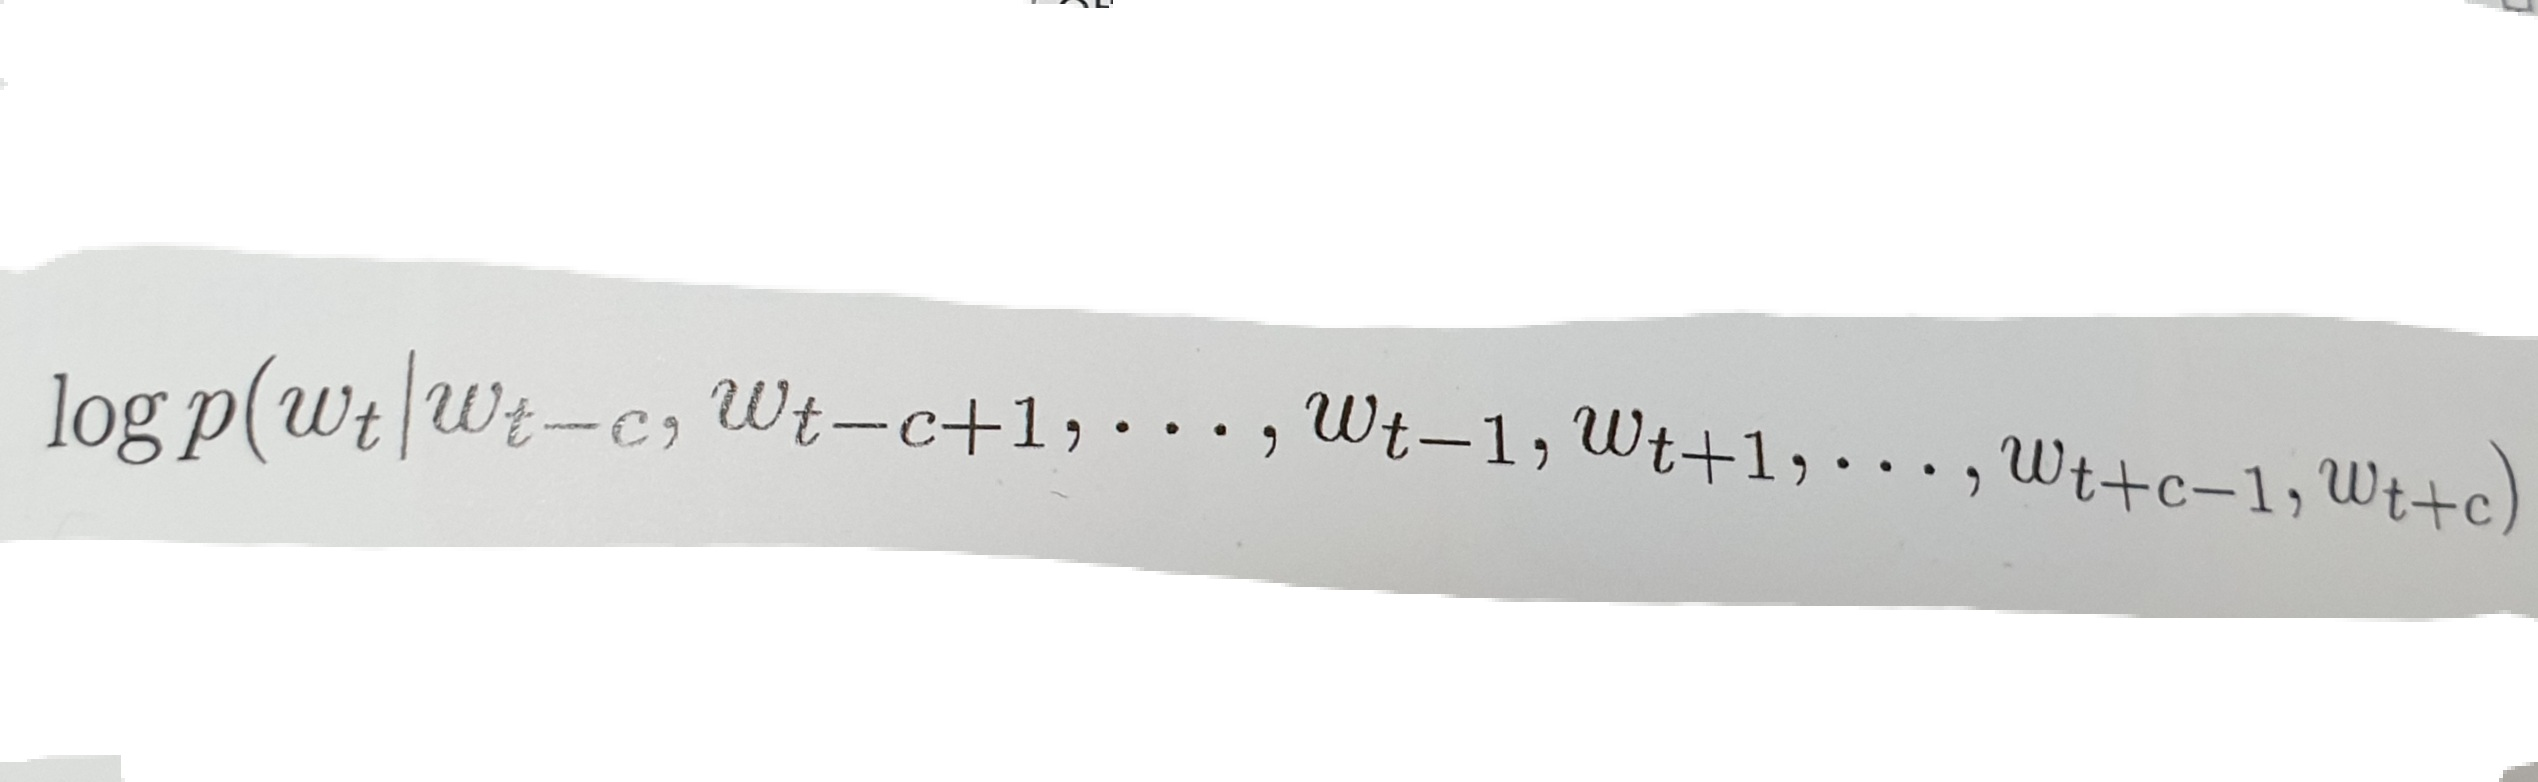    - 앞 뒤로 총 2c개의 단어 모음이 있을 때 t번째 위치에 올 단어에 대한 확률 분포를 찾는 언어 모델

이처럼 단어들의 모음에 대한 확률 분포를 찾는 것을 언어 모델이라고 한다.   

언어 모델은 자연어 처리 분야에서 사전 학습 문제로 활발히 사용  
- 언어 모델을 예측하기 위한 데이터는 라벨이 필요 없기 때문
- 텍스트 데이터 자체가 입력값이 되고 라벨, 즉 정답이 없음
- 그렇기에 언어 모델을 학습하는 것을 비지도 학습이라 부름 
- 언어 모델은 텍스트 데이터를 통해 인간의 의미적, 문법적 정보를 배움
- 텍스트 데이터의 크기가 커질수록 다양한 정보를 배움 

→ 따라서 버트는 사전 학습 과정을 통해 텍스트에 대한 전반적인 정보 등을 학습 

버트는 2개의 문제를 사전 학습  
1. 마스크 언어 모델 
2. 다음 문장 예측(next sentence prediction)  

#### 마스크 언어 모델 
마스크 언어 모델 : 양방향성을 가지고 언어 모델을 학습하기 위한 방법
1. 입력 문장이 주어진 경우 일부 단어들을 마스킹해서 해당 단어를 모델이 알지 못하도록 가린다. 
2. 그 후 모델을 통해 마스킹된 단어가 무엇인지 예측하게 한다. 
즉, 입력값으로 들어간 문장 안의 다른 단어들을 통해 마스킹된 단어를 예측하도록 하는 것  
이 때 양방향성이 생긴다는 것은 기존 언어 모델과의 차이점  

기존 언어 모델 학습은 앞의 단어들을 사용해 다음 단어를 예측하는 방식, 버트의 경우 특정 단어를 가리고 앞뒤 상관없이 **문장 안의 단어들을 모두 사용**해서 가려진 단어들을 예측하게 함으로써 양방향의 단어들을 모두 사용  

-|입력값
---|---
입력값|딥러닝 자연어 처리 공부는 매우 재밌고 유익하다. 
마스킹 후보| 딥러닝 자연어 **처리** 공부는 **매우** 재밌고 **유익하다**
마스킹 후 입력값|딥러닝 자연어 [MASK] 공부는 **내일** 재밌고 **유익하다**

이를 자세히 살펴보면  
- 입력값의 단어 중 15%의 단어들을 마스킹  

*예를 들어) 총 100개의 단어가 모델의 입력값으로 들어가게 되면 확률적으로 15개의 단어를 가지로 입력값으로 넣는다. 그리고 이렇게 가린 15%의 단어들을 모델이 예측하게 하는 것*  

하지만 버트는 성능 향상을 위해 추가적인 조건을 사용  
1. 마스킹 되는 단어들의 80%는 [MASK]라는 스페셜 토큰 사용 
2. 10%는 임의의 다른 단어로 대체 
3. 나머지 10%의 경우 마스킹하지 않고 단어 그대로 모델에 넣음  

버트에서 사용하는 사전 학습 문제인 **다음 문장 예측**은 입력으로 주어진 두 문장이 이어진 문장인지 아닌지를 예측하는 것을 학습.  
즉, 데이터셋을 구성할 때 한 문장에 대해 50%의 확률로 다음 문장을 이어서 모델의 입력값으로 넣고, 나머지 50%의 확률로 임의의 다른 문서의 문장을 기존 문장과 함께 입력값으로 넣는다.   

다음 문장 예측 문제를 학습하기 위해 추가적인 입력값이 두 문장과 함께 들어가게 되는데  

**[CLS] : 다음 문장인지 여부에 대한 이진 분류 예측을 위해 모든 입력값 앞에 넣는 스페셜 토큰**  
**[SFP] : 모델이 각 문장을 구분할 수 있도록 각 문장이 끝나는 지점에 넣어주는 스페셜 토큰**

버트가 사전 학습하는 이유는 버트의 하위 문제 중 두 문장 간의 관계를 예측하는 문제에 도움을 주기 위해서. 
즉, 다음 문제 예측 문제를 사전 학습함으로써 문장 간의 관계를 학습하게 되는 것. 

*EX) [CLS] 딥러닝 자연어 [MASK] 공부는 [MASK] 재밌고 유익하다 [SEP]내일 날씨는 [MASK] 예정입니다 [SEP]*  

이렇게 구성된 입력값에 대해 모델은 마스킹된 '처리', '매우', '맑을' 단어들을 예측하고, 위 두 문장이 이어진 문장인지 판단해 두 문장이 이어지지 않았다는 것을 예측한다. 


### 2) 버트의 모델  
- 버트의 모델은 트랜스포머 모델 구조를 사용 
- 트랜스포머 모델의 인코더 부분만 사용해 모델을 학습 
- ReLU함수 대신 **GELU**함수 사용 
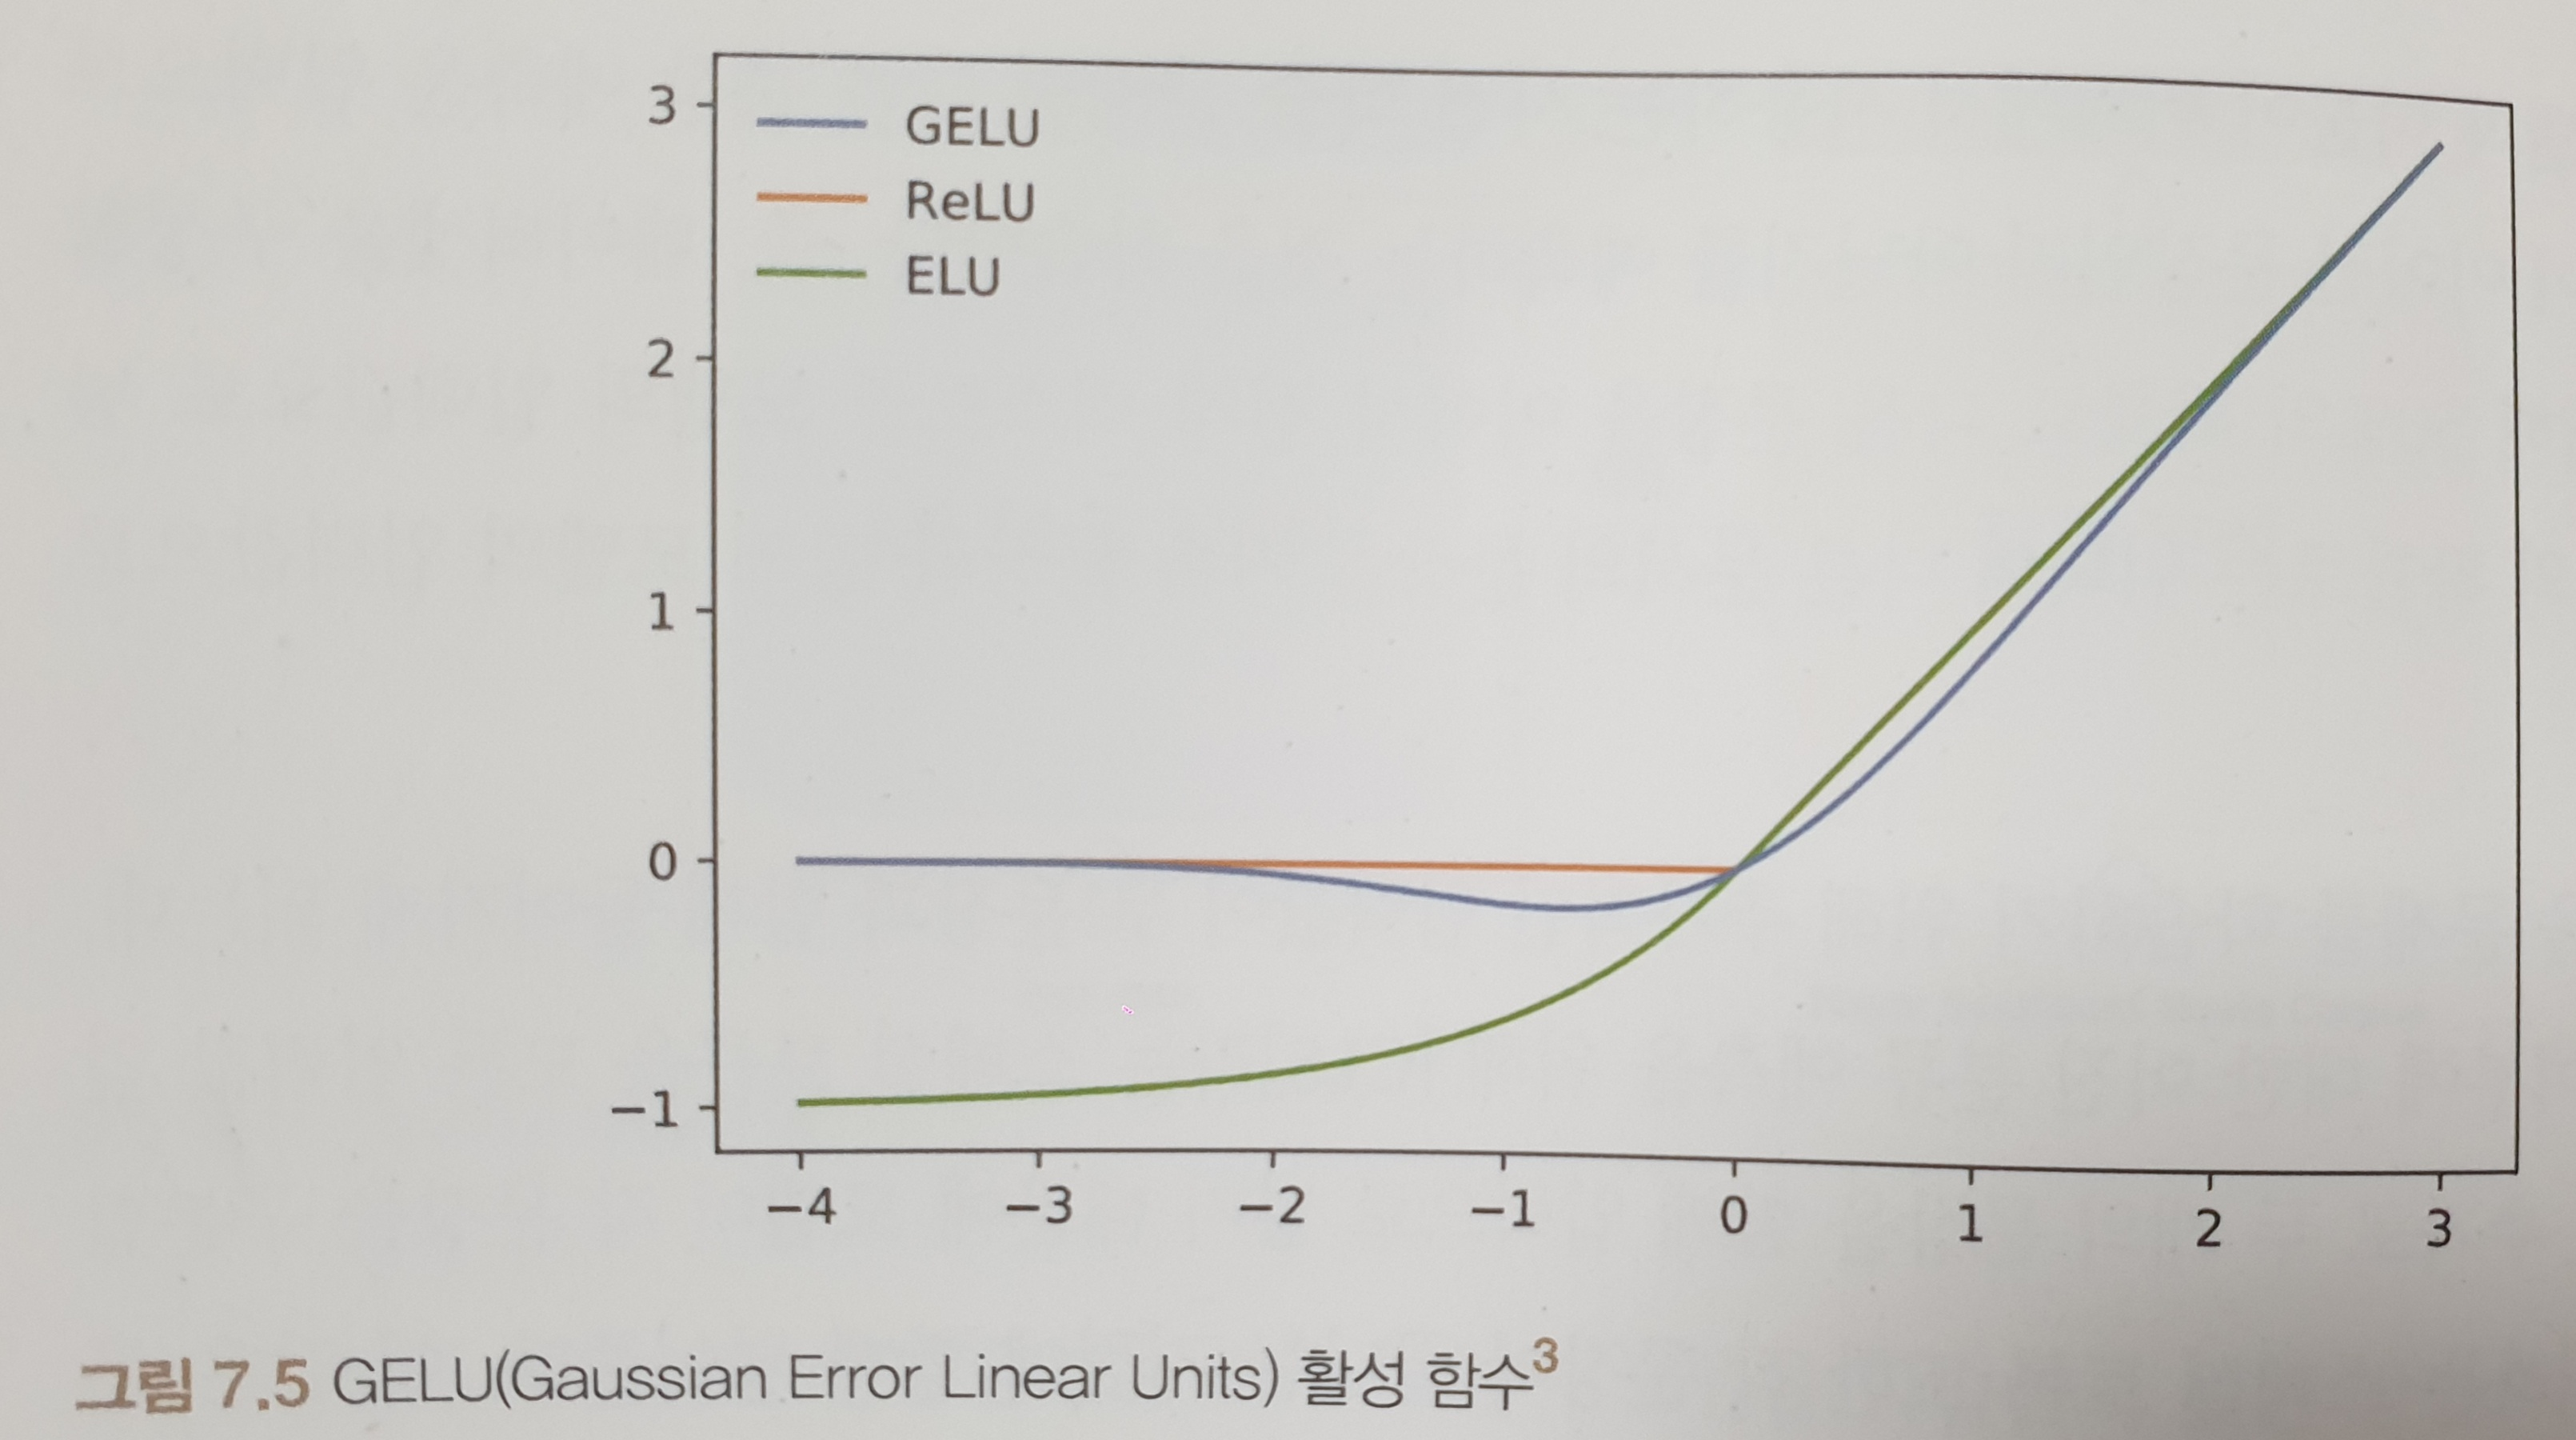정규 분포의 누적분포함수인 GELU는 ReLU보다 0주의에서 부드럽게 변화해 학습 성능을 높임

추가로 버트에서는 트랜스포머 모델 크기에 따라 두 개의 하이퍼파라미터 설정을 사용  
더 작은 크기의 모델을 **버트 베이스(BERT BASE)**  
크기가 큰 모델을 **버트 라지(BERT LARGE)**  

.|L|H|A|전체 파라미터 수  
-|-|-|-|-   
버트 베이스|12|768|12|110M  
버트 라지|24|1024|16|340M
  
- L : 트랜스포머 층(블록)의 개수 
- H : 모델의 전체적인 차원 수 
- A : 멀티 헤드 어텐션에서의 헤드의 개수  

- 버트의 경우 사전 학습했던 가중치를 그대로 사용 하기 때문에 미세 조정 후의 모델도 동일한 모델 크기를 사용  
- 따라서 큰 모델 사이즈로 사전 학습한 모델의 경우 미세 조정 또한 학습에 많은 리소스를 필요

### 3) 버트의 미세 조정  
사전 학습된 가중치를 가지고 있는 버트는 여러 하위 문제에 미세 조정(fine-turning)될 수 있다.  
다음 그림은 사전 학습한 버트 모델을 MNLI, NER, SQuAD라는 다양한 자연어 처리 하위 문제에 미세 조정하는 것을 의미  
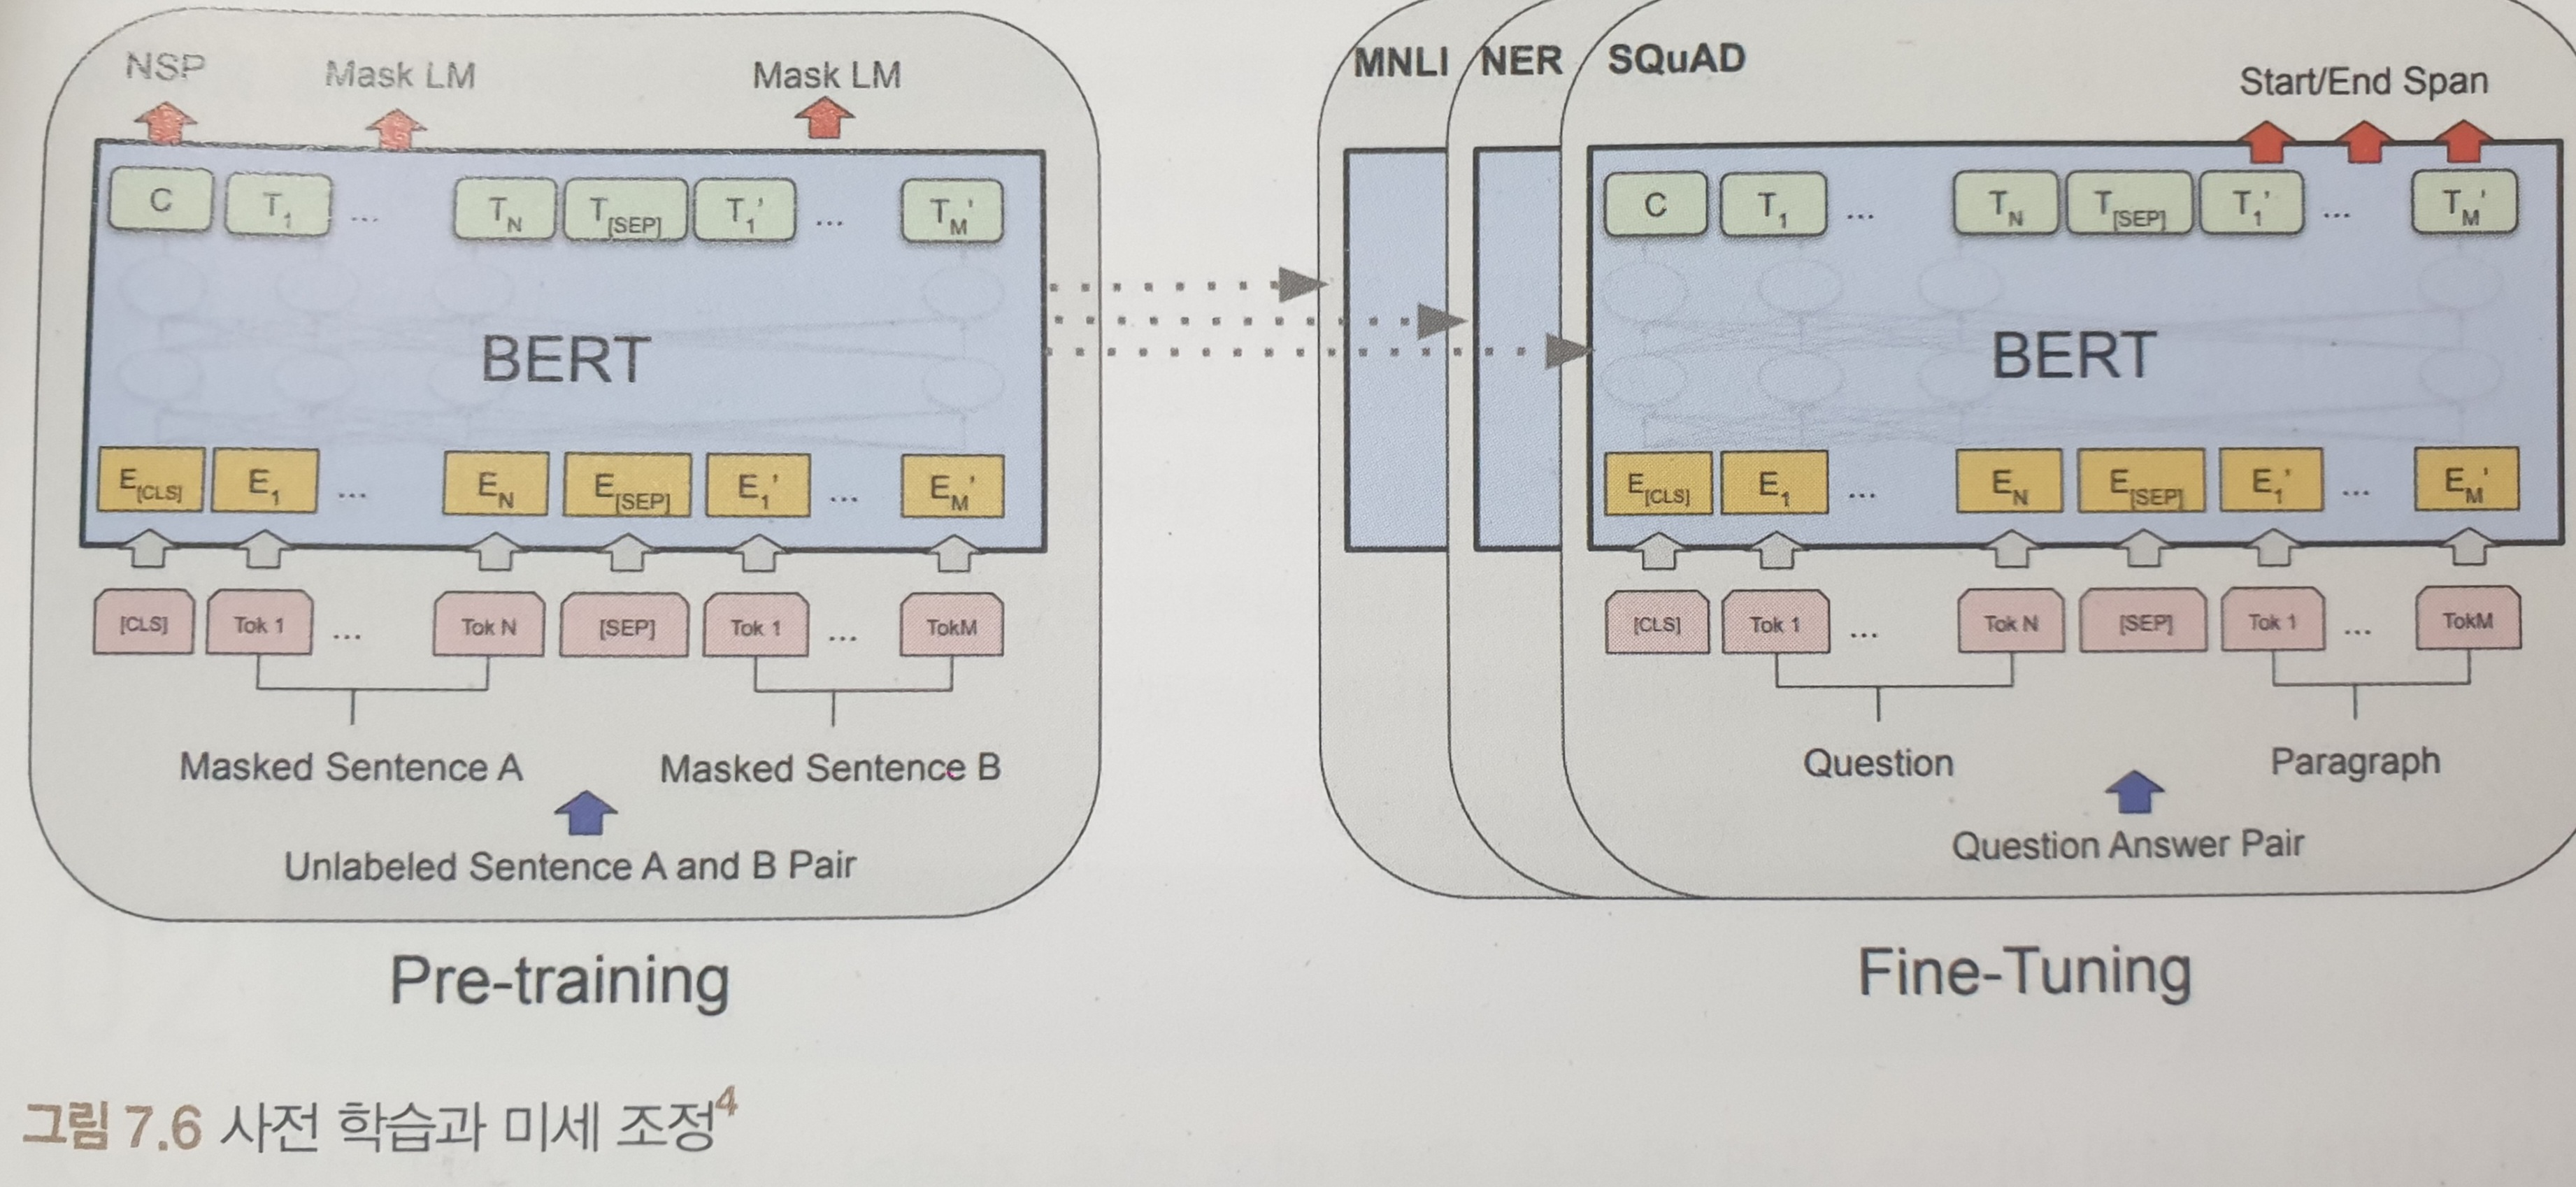
- 사전 학습한 버트 모델을 하위 문제에 미세 조정함으로써 사전 학습 없이 학습한 모델보다 더욱 높은 성능을 얻을 수 있음. 

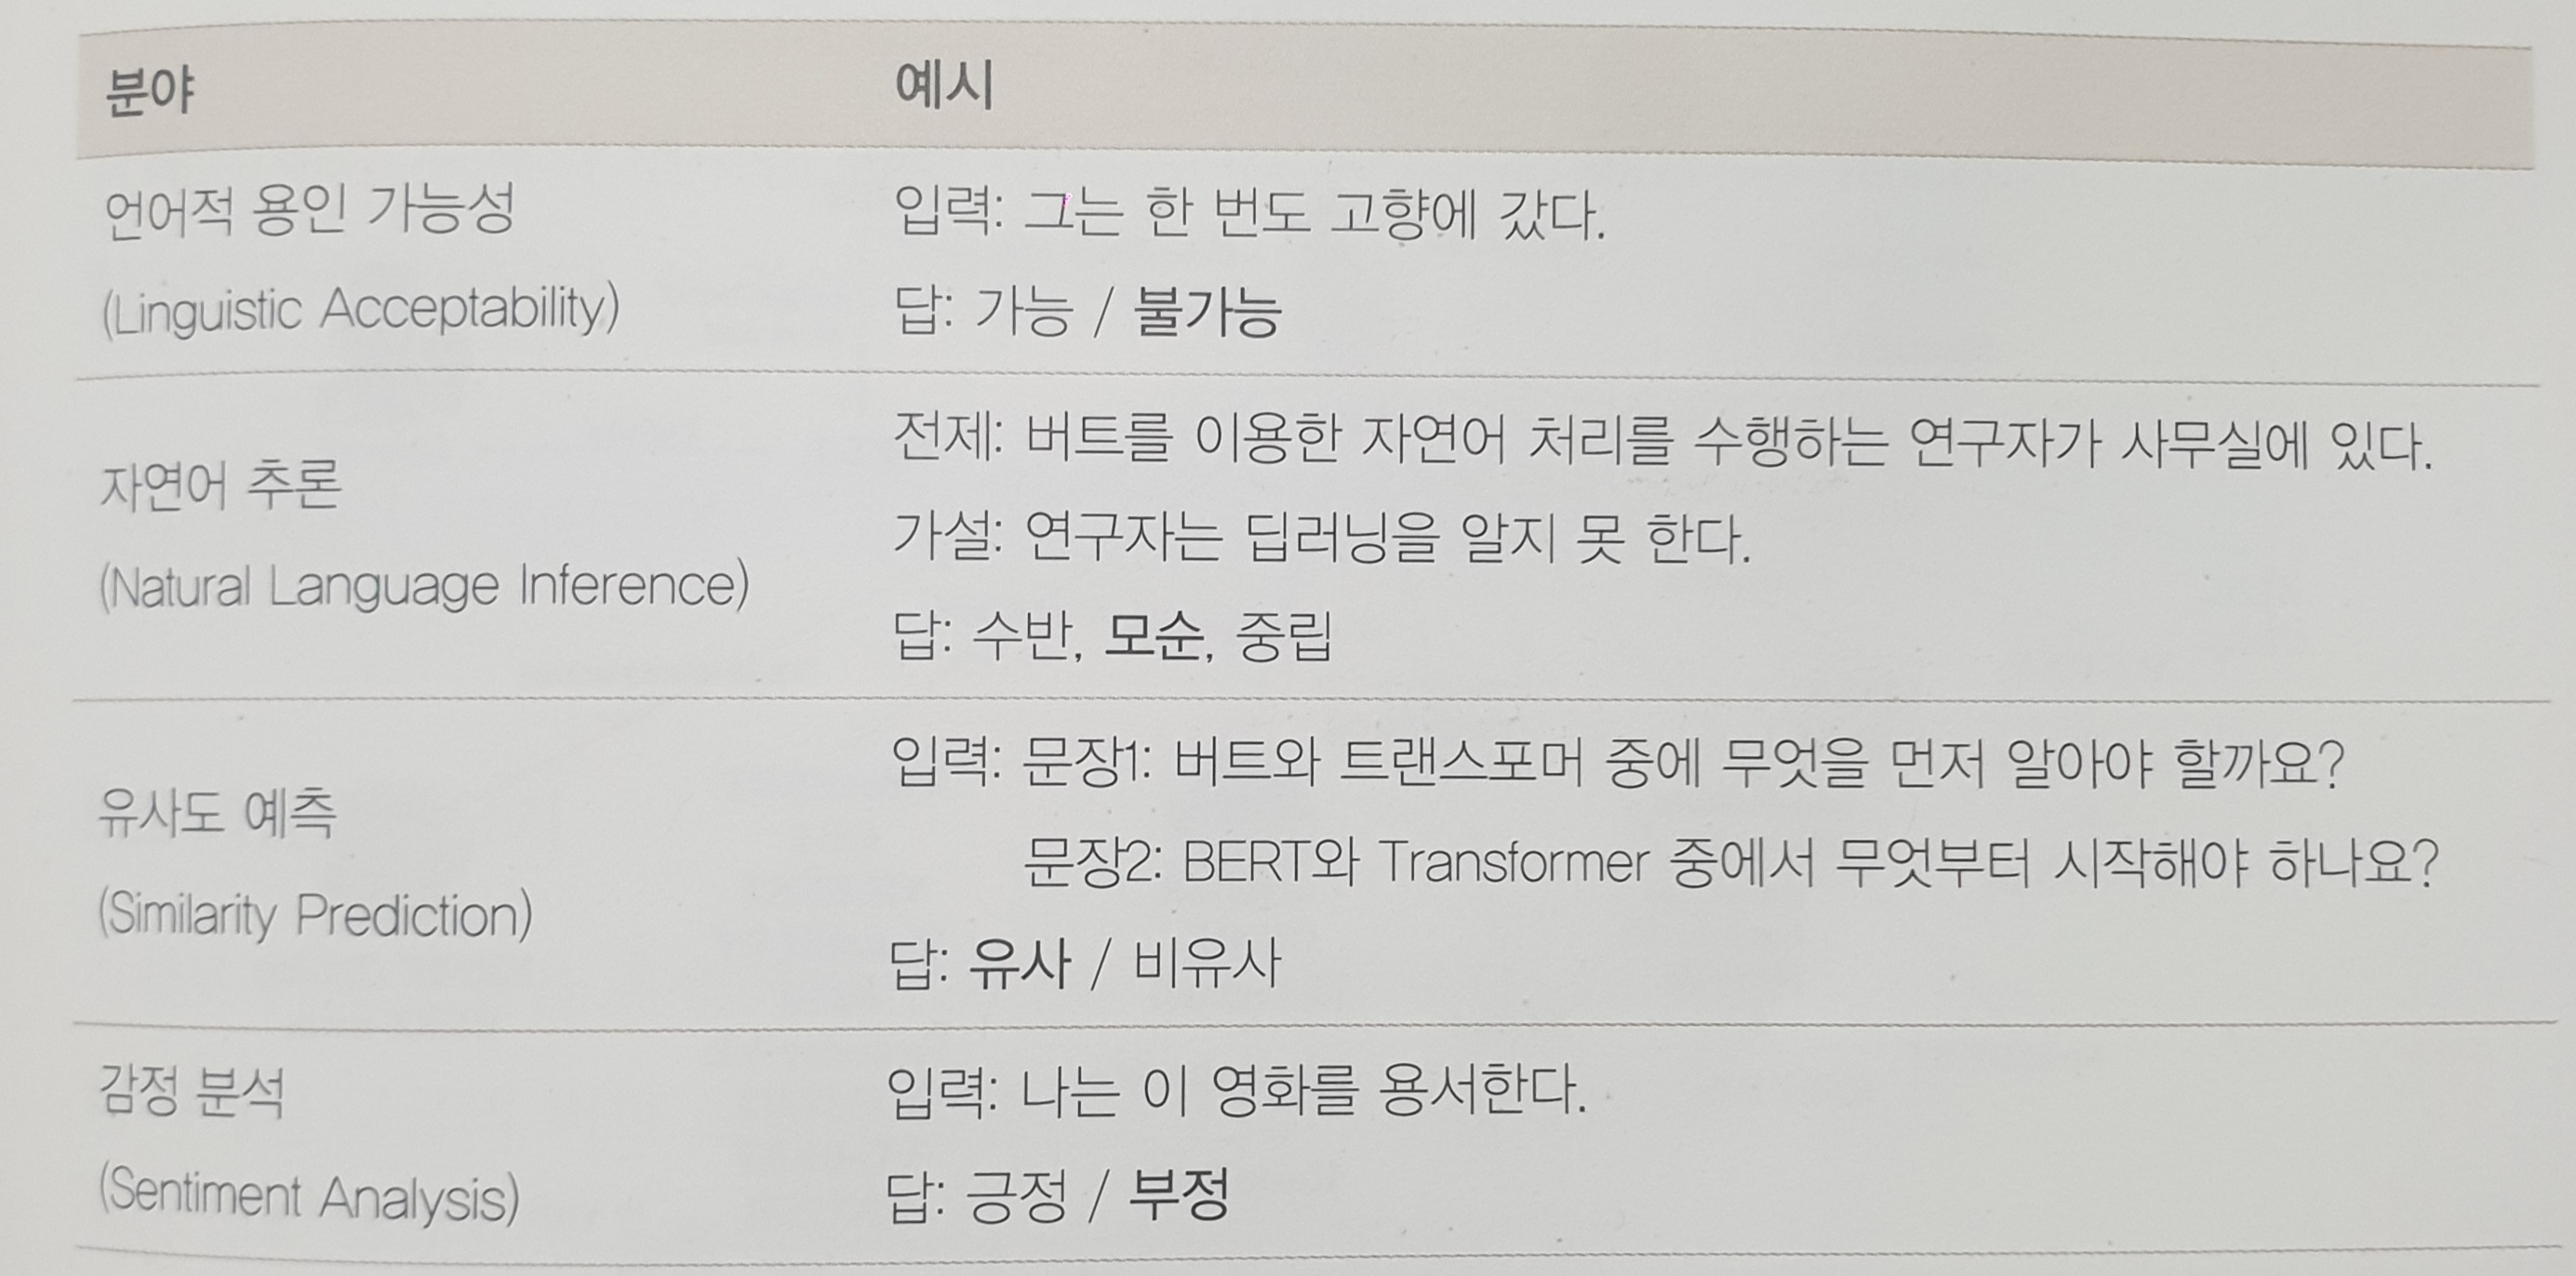

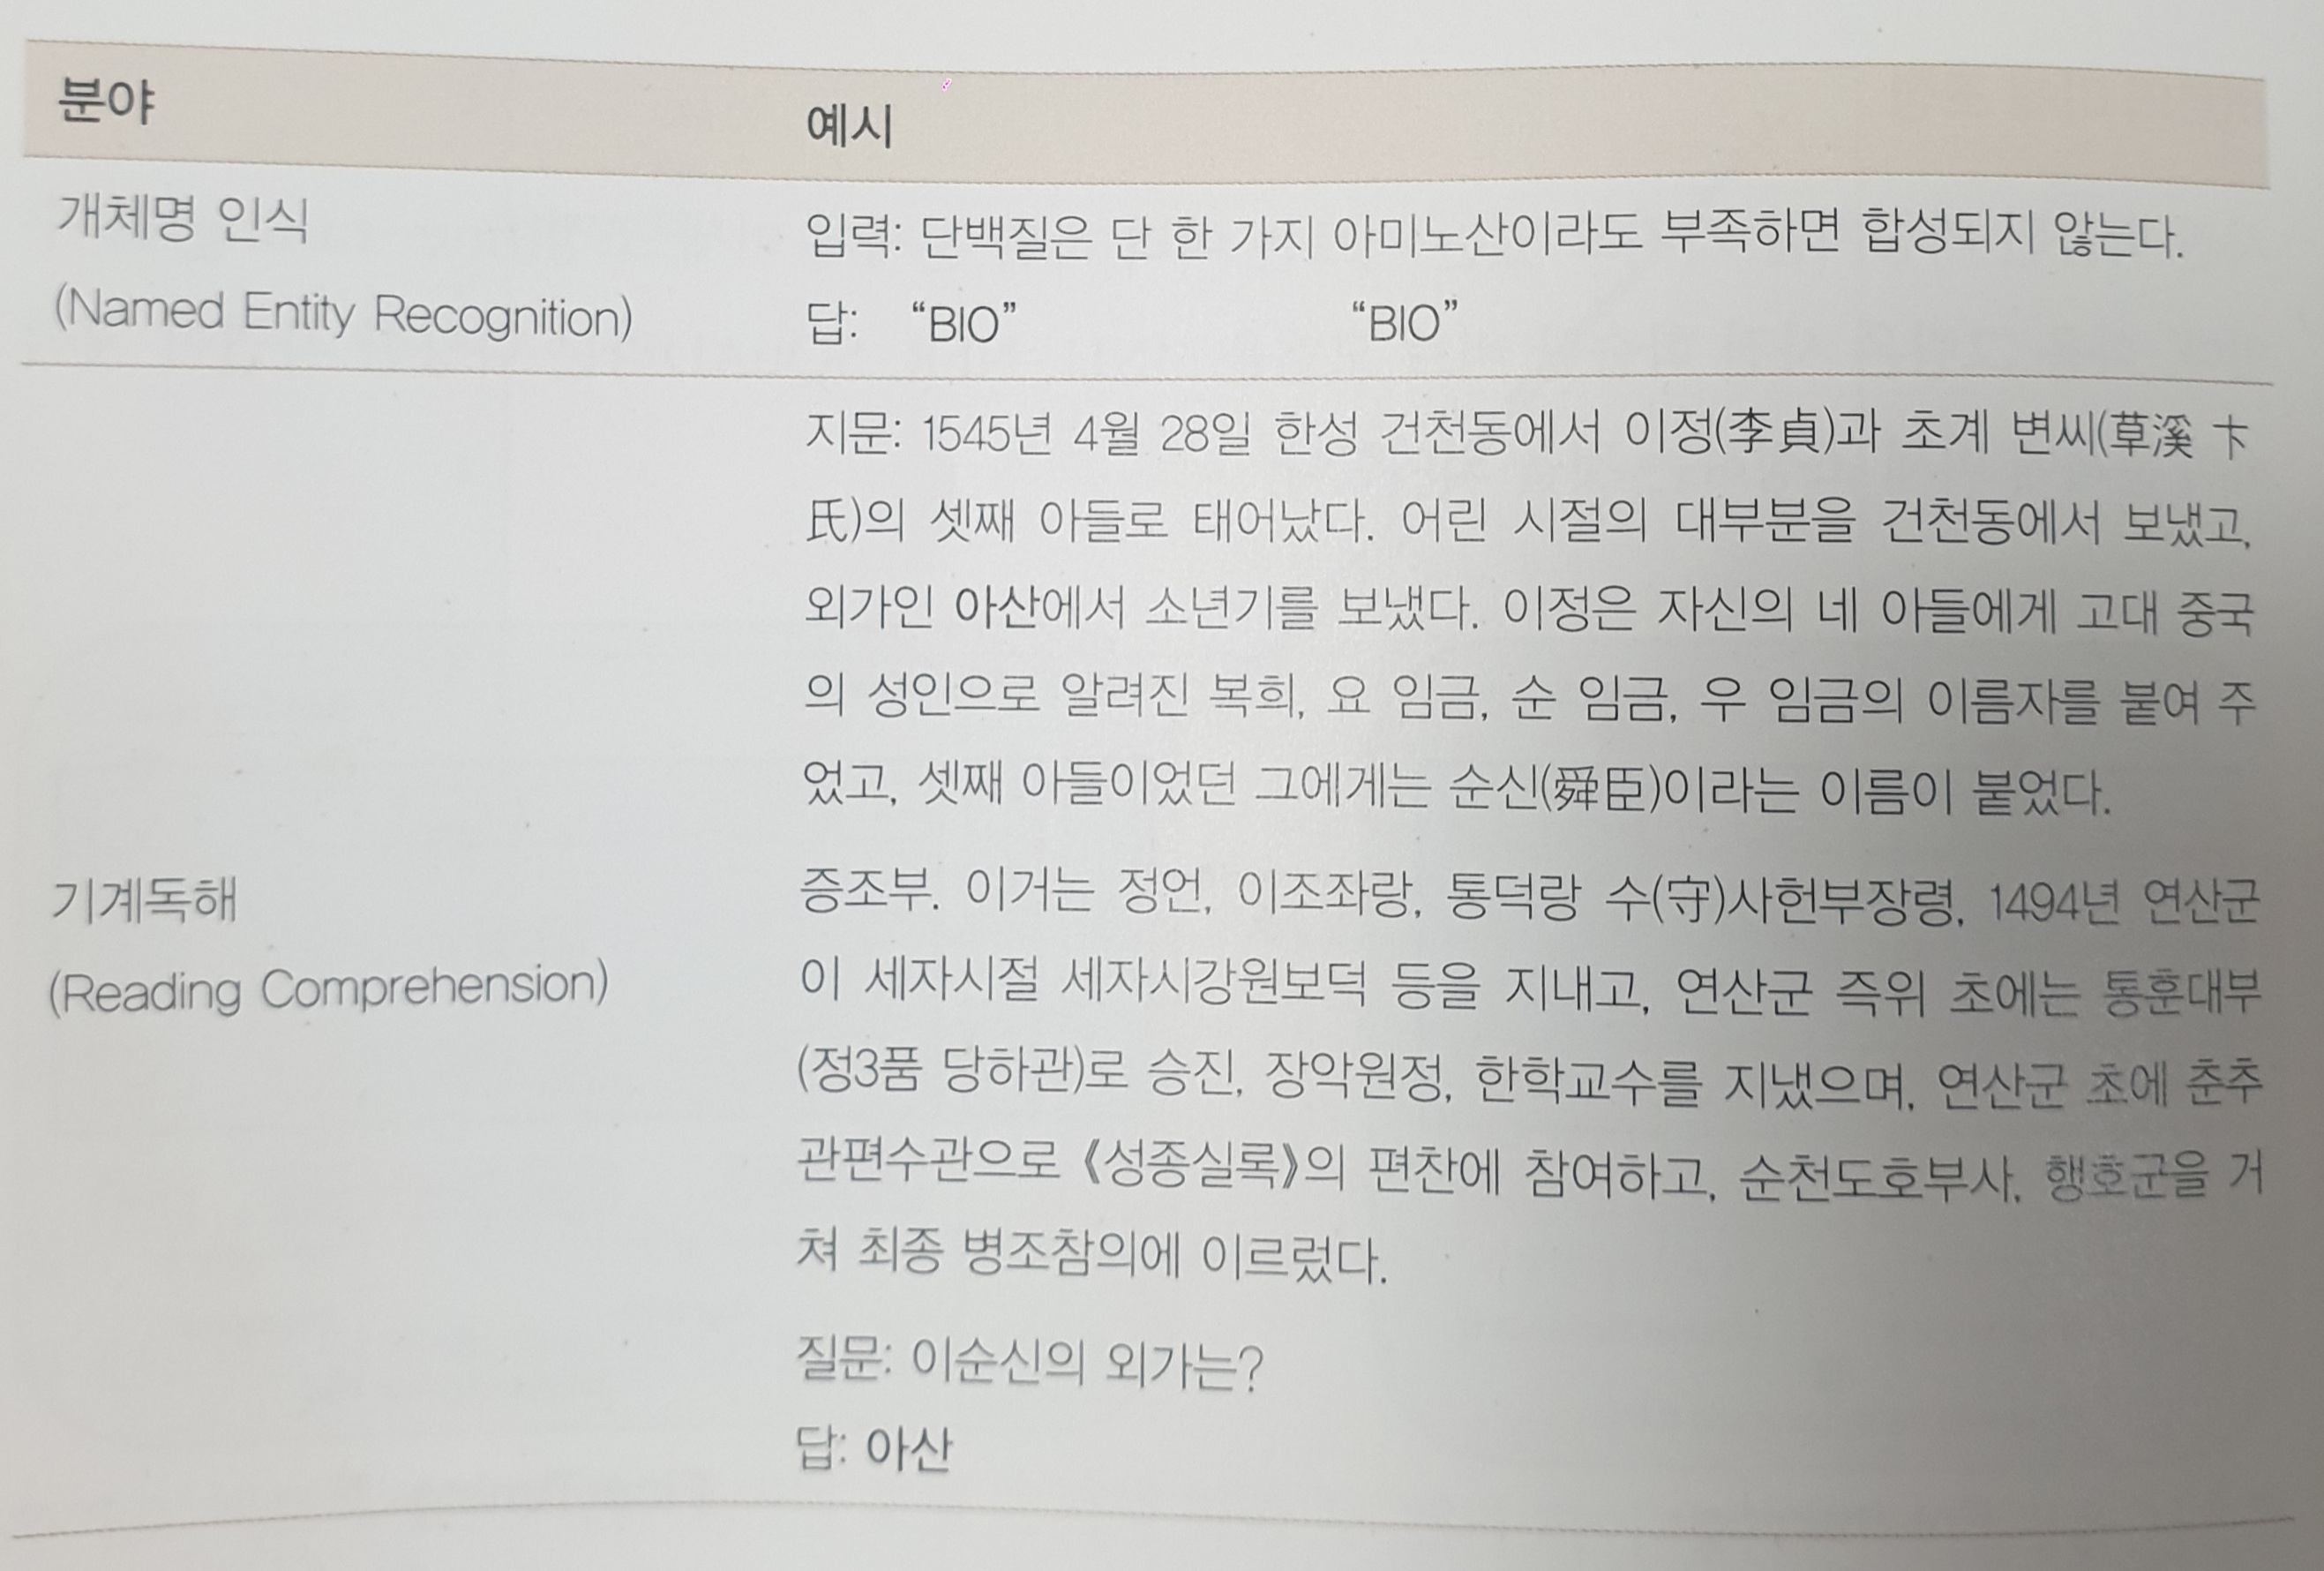  
버트의 사전 학습을 통한 자연어 처리의 예 

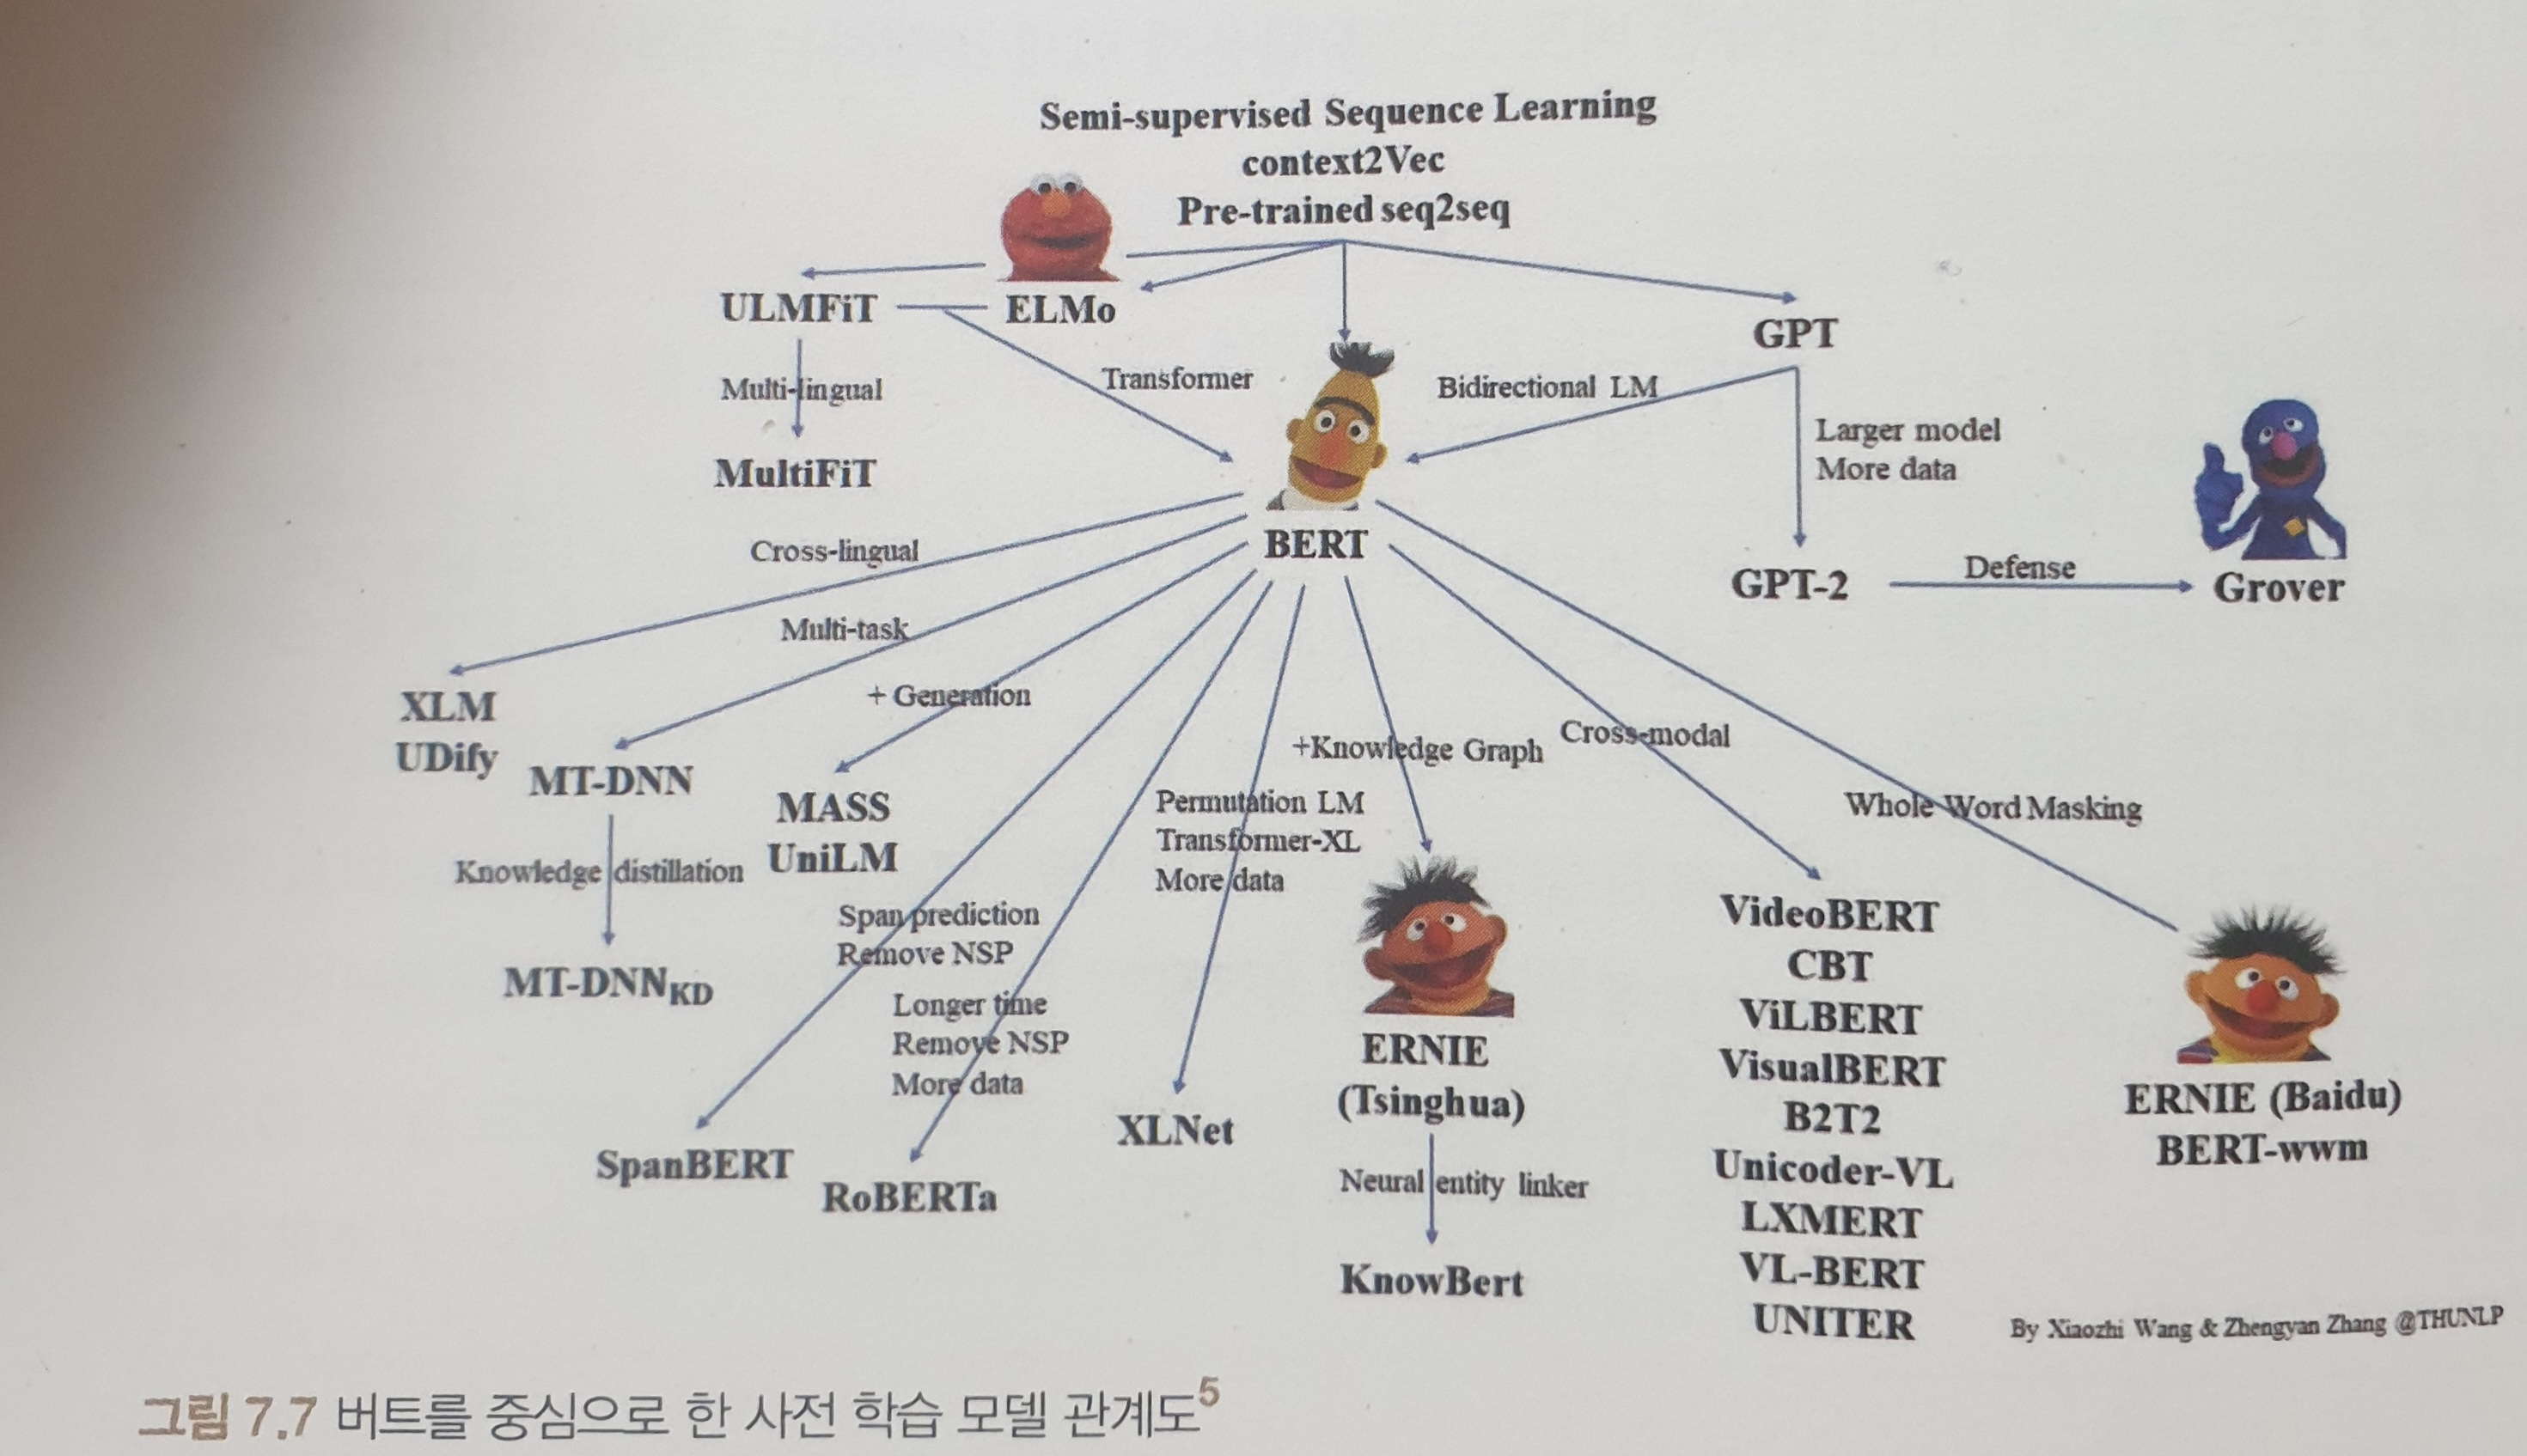
버트를 중심으로 한 사전 학습 모델 관계도  

버트를 중심으로 많은 모델들이 탄생
각 모델은 크게 **세 가지 특징**을 기준으로 분류. 
1. 버트를 개선하려고 노력한 모델(성능 향상, 속도 개선, 메모리 최적화 등)  
2. 버트의 알고리즘 문제를 실험적으로 증명하며 개선하려는 모델 
3. 버트를 자연어 처리 분야가 아닌 다른 영역에서 활용하는 모델(ex 동영상 분야, 시각적 분야) 

## 1. 버트를 활용한 미세 조정 학습 
**버트 실전 문제 적용**  
- 문장 분류 
- 자연어 추론  
- 개체명 인식
- 텍스트 유사도
- 기계 독해 문장  
  
이 중에서 문장 분류 부분만 간단하게 살펴보겠습니다.  

In [7]:
# 라이브러리 설치
pip install transformers

     |████████████████████████████████| 1.5MB 20.6MB/s 
     |████████████████████████████████| 2.9MB 38.6MB/s 
     |████████████████████████████████| 890kB 45.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=8fae922fca04cfaffce24d52027d6579da05730e8045d831bc39a654bef714b6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### 1) 버트 파일 불러오기 
버트를 활용하기 위한 두 가지 모듈 
1. 데이터 전처리 토크나이저 
2. 가중치 모델  

전처리의 경우 모델을 사전 학습시킬 때와 동일한 규칙을 사용하기 때문에 모델을 학습할 때 사용했던 것을 사용

In [26]:
# 다국어 토크나이저
from transformers import *

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

### 2) 버트 문장 전처리 진행하기 
문장을 버트의 입력값으로 활용하기 위해서는 특정 분야(분류, 유사도, 추론 등)에 맞게 다양한 입력값으로 치환  
**버트 모델의 3가지 입력값**  
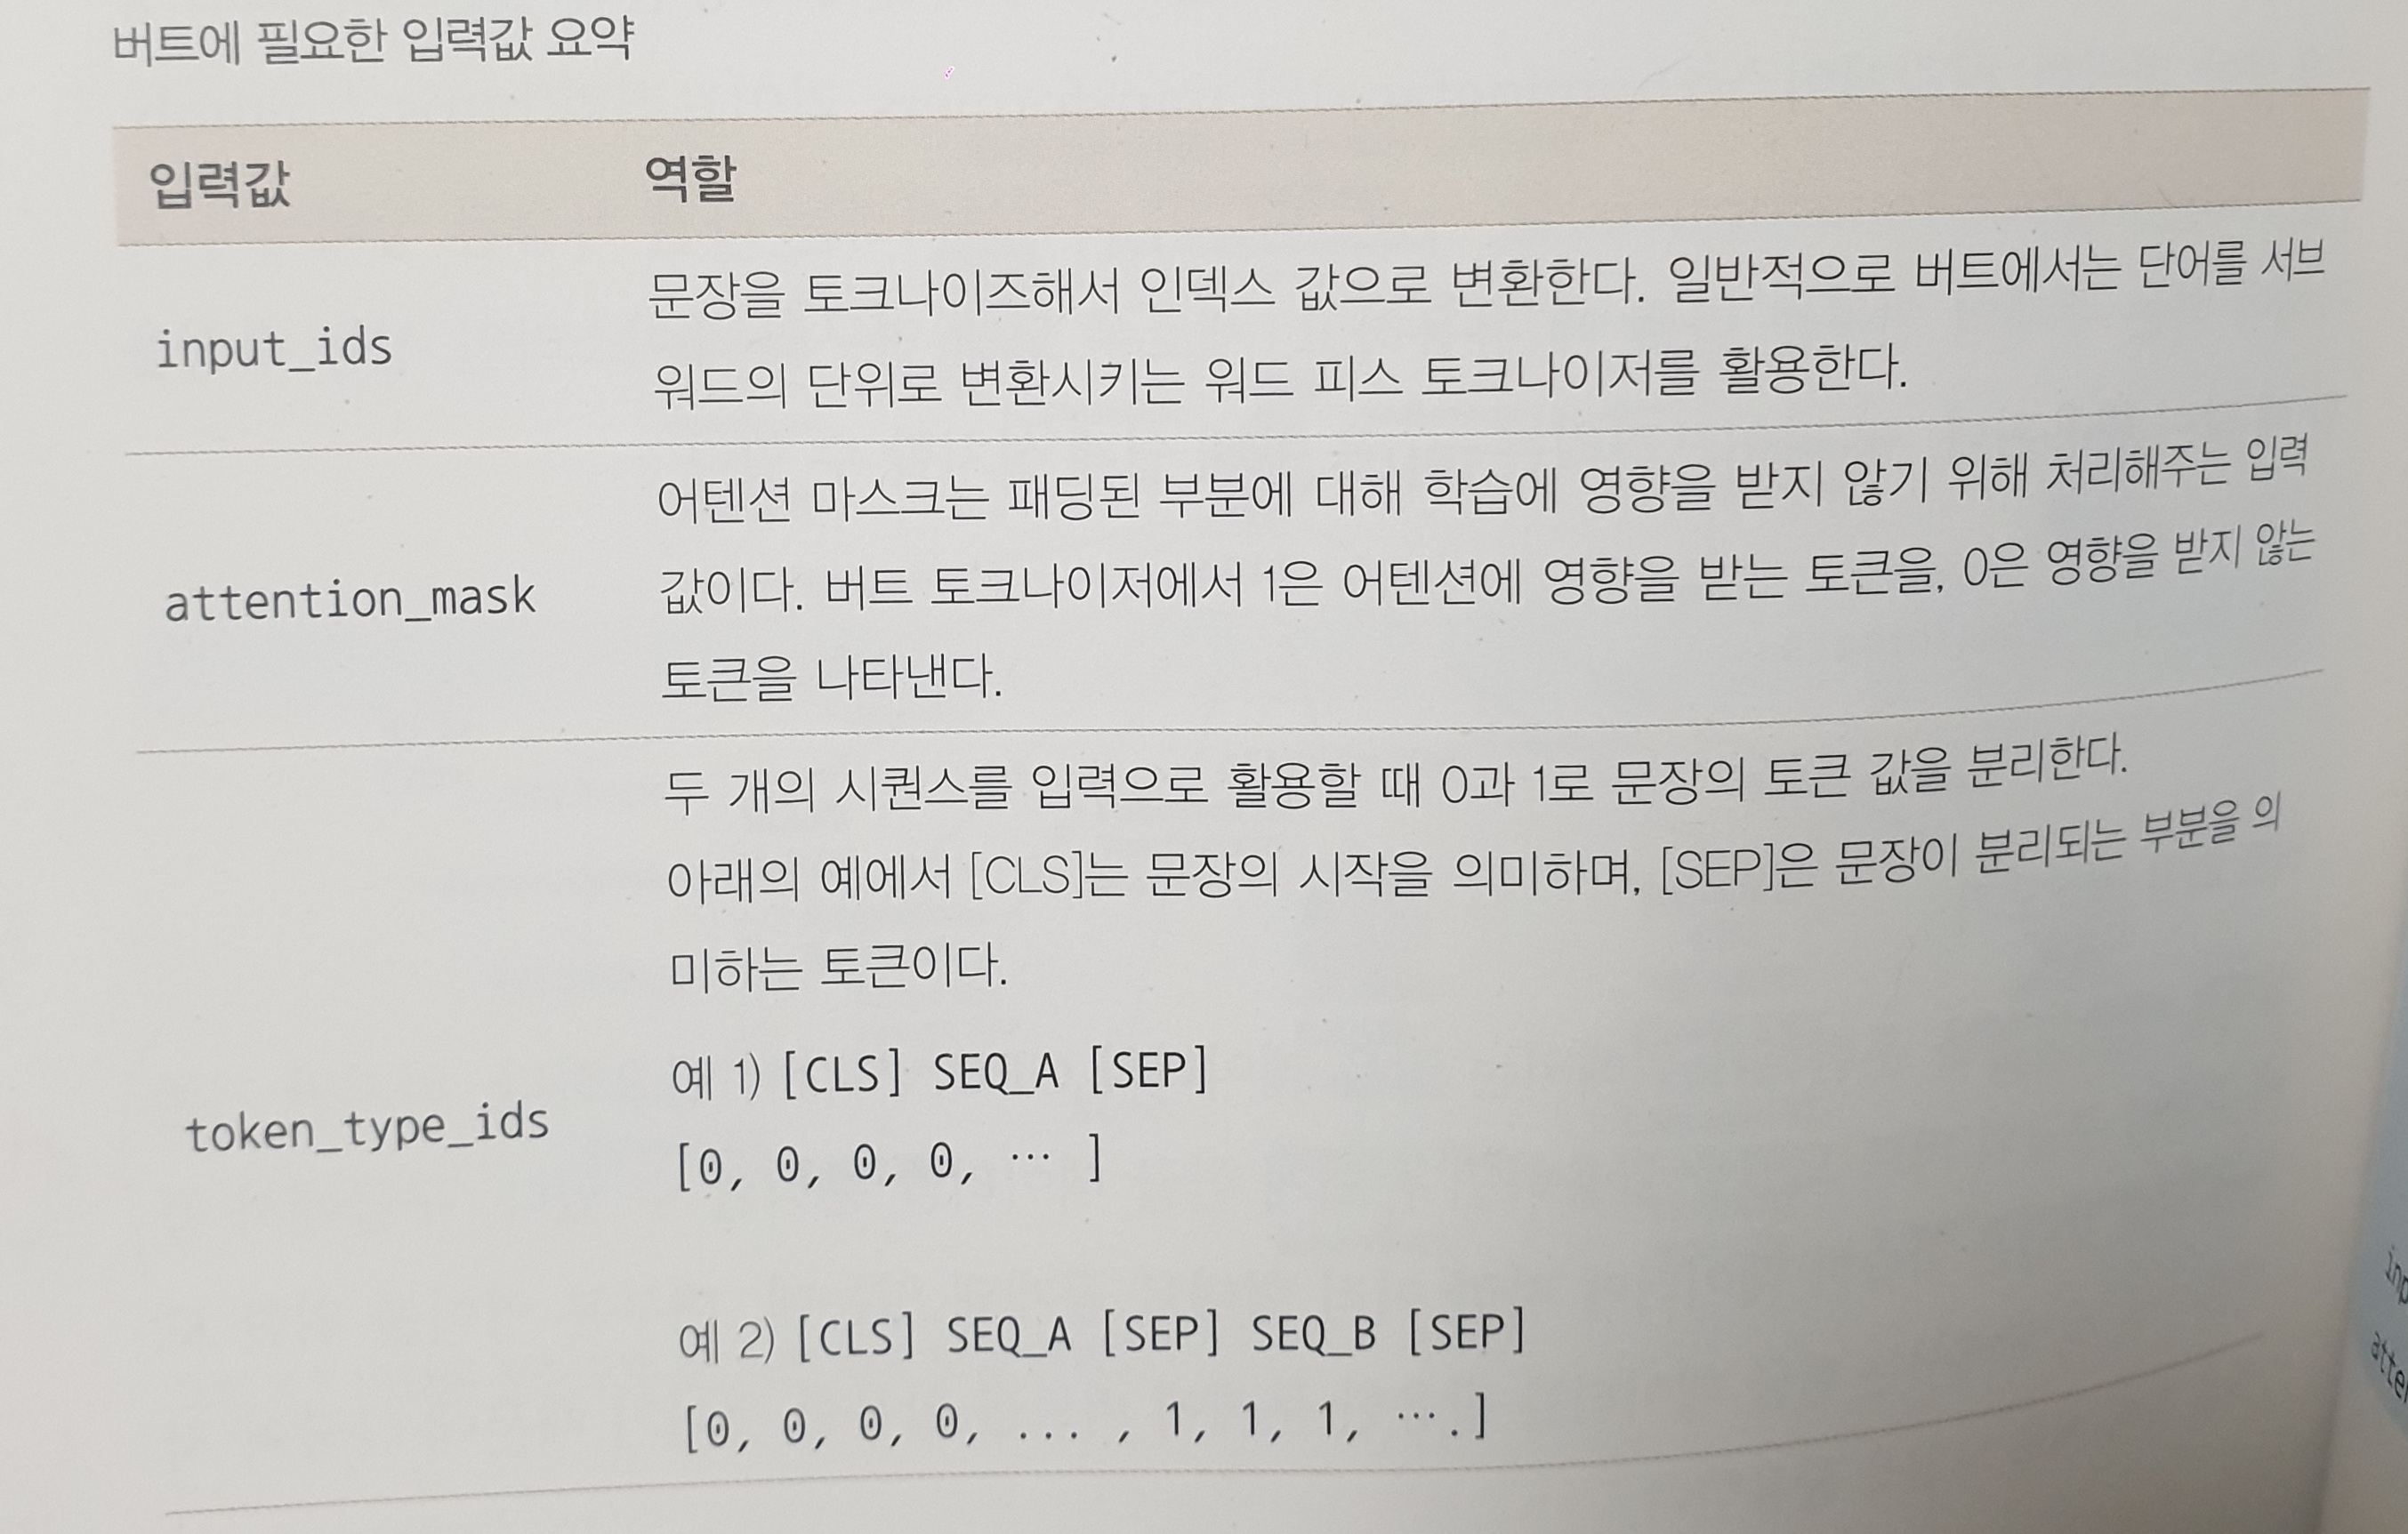

버트 토크나이저에서는 문장의 시작이나 끝, 모델별 목적에 맞게 스페셜 토큰을 활용  

스페셜 토큰|역할
---|---
[UNK]|모르는 단어에 대한 토큰
[MASK]|마스크 토큰, 사전 학습에서 활용  
[PAD]|최대 길이를 맞추는 용도   
[SEP]|문장의 종결을 알림  
[CSL]|문장의 시작을 알림  

#### `encode_plus` 기능
- 버트 토크나이저 작업에 필요한 구조를 만들어 줌
- 특정 문장을 버트에 필요한 입력 형택로 변환
- 문장을 최대 길이에 맞게 패딩  
- 결괏값은 딕셔너리로 출력   


#### `encode_plus`의 변환되는 순서
1. 문장을 토크나이징한다. 
2. `add_special_tokens`를 `True`로 지정하면 토큰의 시작점에 '[CLS]'토큰, 토큰의 마지막에 '[SEP]'토큰을 붙인다. 
3. 각 토큰을 인덱스로 변환한다. 
4. `max_length`에 `MAX_LEN` 최대 길이에 따라 문장의 길이를 맞추는 작업을 진행하고, `pad_to_max_length` 기능을 통해 `MAX_LEN`의 길이에 미치지 못하는 문장에 패딩을 적용한다. 
5. `return_attention_mask` 기능을 통해 어텐션 마스크를 생성한다. 
6. 토큰 타입은 문장이 1개일 경우 0으로, 문장이 2개일 경우 0과 1로 구분해서 생성한다. 

## 2. 버트를 활용한 한국어 텍스트 분류 모델   

버트의 미세 조정을 활용하기 위해 텍스트 분류 분야에 해당하는 감정 분석 문제에 적용  


### 1) 네이버 영화 리뷰 데이터 전처리   

In [8]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

#### 기본 세팅
- 기본적인 세팅을 설정한다. 

In [10]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 39 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

- 먼저 버트의 다국어(102개 언어) 토크나이저를 한글에 적용한다.

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

#### 토크나이저 테스트

In [12]:
test_sentence = "안녕하세요, 반갑습니다."

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
['[ C L S ]', '안', '# # 녕', '# # 하', '# # 세', '# # 요', ',', '반', '# # 갑', '# # 습', '# # 니 다', '.', '[ S E P ]']


In [13]:
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")
kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
# [101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
print(eng_encode)
# [101, 31178, 11356, 102]
print(kor_decode)
# [CLS] 안녕하세요, 반갑습니다 [SEP]
print(eng_decode)
# [CLS] Hello world [SEP]

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] Hello world [SEP]


#### 데이터 전처리 준비

In [14]:
# 데이터 전처리 준비
# 데이터 경로 설정 
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1

#### 인코더와 디코더
- 한글과 영어의 인코더와 디코더 영역을 확인한다. 

In [15]:
# 스페셜 토큰
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# 토크나이저 테스트하기
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode) # 인덱스를 다시 문자로 변경 
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] 
 [100, 102, 0, 101, 103]
[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다. [SEP]
[CLS] Hello world [SEP]


In [16]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

이제 다국어 토크나이저와 `encode_plus` 기능을 활용해 영화 리뷰 데이터를 전처리해보자 

In [17]:
# train_data = train_data[:1000] # for test

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# 영화 리뷰에서 한글 외의 텍스트를 제거하기 위한 clean_text 함수를 적용
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-|\\s]", " ", sent)
    return sent_clean

# 버트 토크나이저를 활용한 인코딩 진행
for train_sent, train_label in tqdm(zip(train_data["document"], train_data["label"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

# 최종 출력값은 넘파이로 변환     
train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
# train_movie_inputs에 튜플 형태로 묶어서 저장
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

  0%|          | 0/149995 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 149995/149995 [00:44<00:00, 3347.05it/s]

# sents: 149995, # labels: 149995


전처리 과정은 다음과 같다.  
1. 영화 리뷰에서 한글 외의 텍스트를 제거하기 위한 `clean_text` 함수를 적용 
2. 버트 토크나이저를 활용한 인코딩 진행 
3. 최종 출력값은 넘파이로 변환 
4. `train_movie_inputs`에 튜플 형태로 묶어서 저장  

한글 영화 데이터를 활용했을 때 버트 토크나이저를 통해 실제 어떤 결과가 나오는지 간단한 예를 확인해보자.  

제 3사분위 값인 39를 최대 길이로 정한 후 전체 문장 중 하나를 추출해 출력해 보자.  

In [18]:
# 최대 길이: 39
input_id = train_movie_input_ids[1] # 각 문장이 단어의 부분 단위로 쪼개서 각 숫자에 인덱스 처리
attention_mask = train_movie_attention_masks[1] # 0으로 패딩된 부분을 제외하면 모두 1로 입력 
token_type_id = train_movie_type_ids[1] # 토큰 타입은 1개 문장에 대한 감정 분류 분야이므로 0.

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id)) # 다시 문장으로 변환

[   101    100    119    119    119   9928  58823  30005  11664   9757
 118823  30858  18227 119219    119    119    119    119   9580  41605
  25486  12310  20626  23466   8843 118986  12508   9523  17196  16439
    102      0      0      0      0      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[CLS] [UNK]... 포스터보고 초딩영화줄.... 오버연기조차 가볍지 않구나 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


- "흠...포스터보고 초딩영화줄.../오버연기조차 가볍지 않구나"   
- 문장을 토크나이징한 `input_ids`에서 각 문장이 단어의 부분 단위로 쪼개서 각 숫자에 인덱스 처리
- 해당 문장은 전처리를 진행할 때 최대 길이보다 작기 때문에 뒤에 0으로 패딩  
- 어텐션 마스크를 확인해 보면 뒤에 0으로 패딩된 부분을 제외하면 모두 1로 입력  
- 토큰 타입은 1개 문장에 대한 감정 분류 분야이므로 0.   
- 인덱스된 데이터(input_ids)에서 다시 문장으로 변환하고 싶으면 `tokenizer.decode`를 통해 변환

### 2) 네이버 영화 리뷰 모델 학습   
버트 토크나이저로 인코딩된 데이터를 활용해 학습을 진행  
1. 버트 분류 클래스를 구성 
2. 최적화, 손실값 및 정확도를 선언
3. 학습을 진행하기 위한 compile 진행

In [19]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class): # 활용할 모델 이름, 모델이 저장된 위치, 클래스의 수를 모델에 지정
        super(TFBertClassifier, self).__init__()
# TFBertModel.from_pretrained를 통해 기존에 사전 학습했던 부분 로드
        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path) 
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier") 
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=2)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


 - 사전 학습된 버트 모델을 불러와 그 위에 완전연결층 1층을 쌓는 구조  
 
#### __init__ 매서드 
     - model_name, dir_path, num_class를 인자로 받아 활용할 모델 이름, 모델이 저장된 위치, 클래스의 수를 모델에 지정   

#### self.bert 매서드
     - TFBertModel.from_pretrained를 통해 기존에 사전 학습했던 부분 로드 
     - TFBertModel의 결괏값은 sequence_output, pooled_output, hidden_states, attentions로 구성
     - num_class에 원하는 분류 값을 추가해서 정답의 개수를 정함(여기선 2개(긍정, 부정))

#### call 매서드 
     1. 영화 리뷰 문장 텍스트를 inputs를 통해 받음
     2. 버트에서 outputs로 결괏값을 추출
     3. self.classifier를 통해 완전 열결층을 활용
     4. 최종적으로 self.num_labels개수에 맞는 예측값을 출력  
     
**핵심은 버트의 사전 학습된 부분을 불어와서 그 이후에 다양한 종류의 자연어 문제에 적용하는 것**   

In [20]:
# TFBertClassifier를 활용해 최적화, 손실 값 및 평가 기준을 설정하는 과정 
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5) # 최적화 방법으로 아담 최적화 사용 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # 크로스엔트로피 손실 값을 측정하기 위해 SparseCategoricalCrossentropy 사용, 여기서 정답은 정수 형태
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy') # 모델의 정확도를 측정하는 SparseCategoricalAccuracy를 정의 
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric]) # compile함수를 넣어 모델을 학습할 준비 

**GPU를 사용!!!**

In [21]:
model_name = "tf2_bert_naver_movie"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)

data_out/KOR/tf2_bert_naver_movie -- Folder already exists 

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f4501ff0e58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f4501ff0e58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


3750/3750 [==============================] - ETA: 0s - loss: 0.4585 - accuracy: 0.7731

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


3750/3750 [==============================] - 1264s 327ms/step - loss: 0.4585 - accuracy: 0.7731 - val_loss: 0.3384 - val_accuracy: 0.8500

Epoch 00001: val_accuracy improved from -inf to 0.84996, saving model to data_out/KOR/tf2_bert_naver_movie/weights.h5
Epoch 2/3
3750/3750 [==============================] - 1221s 326ms/step - loss: 0.3138 - accuracy: 0.8633 - val_loss: 0.3398 - val_accuracy: 0.8590

Epoch 00002: val_accuracy improved from 0.84996 to 0.85900, saving model to data_out/KOR/tf2_bert_naver_movie/weights.h5
Epoch 3/3
3750/3750 [==============================] - 1222s 326ms/step - loss: 0.2541 - accuracy: 0.8934 - val_loss: 0.3163 - val_accuracy: 0.8633

Epoch 00003: val_accuracy improved from 0.85900 to 0.86326, saving model to data_out/KOR/tf2_bert_naver_movie/weights.h5
{'loss': [0.40477806329727173, 0.3130342662334442, 0.25870490074157715], 'accuracy': [0.8109686970710754, 0.8633370995521545, 0.8908796906471252], 'val_loss': [0.33836469054222107, 0.3398013114929199, 0.

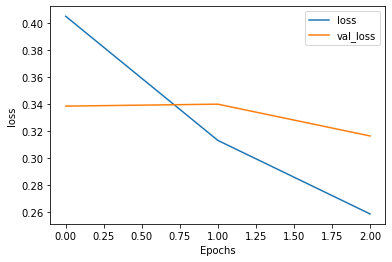

In [22]:
plot_graphs(history, 'loss')

검증 데이터를 기반으로 해당 데이터는 약 3에폭 학습했을 때 좋은 성능을 내는 것을 확인  

### 3) 네이버 영화 리뷰 모델 테스트 

버트 토크나이저와 encode_plus를 사용해 영화 리뷰 테스트 데이터 전처리  
최종적으로 evaluate 기능을 통해 결괏값 출력

In [23]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0

In [24]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(test_data["document"], test_data["label"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
49997it [00:14, 3336.99it/s]


num sents, labels 49997, 49997


In [25]:
results = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

49/49 [==============================] - 132s 3s/step - loss: 0.3194 - accuracy: 0.8614
test loss, test acc:  [0.3194406032562256, 0.8614316582679749]


4장 CNN과 비교  

-|CNN Classifier|BERT Classifier
-|-|-
Score|82.63%|86.14%